# 0.0 IMPORTS 

In [76]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import scikitplot as skplt 

from tabulate import tabulate
from matplotlib import pyplot as plt
from IPython.core.display    import HTML
from sklearn import model_selection as ms
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.model_selection import feature_importances
from sklearn.preprocessing import MinMaxScaler,StandardScaler

# 0.1 HELPS FUNCTIONS

In [77]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def percentage (x):
    p = x * 100 
    
    return p

In [78]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# 0.2 LOADING THE DATAS

In [79]:
df_raw = pd.read_csv('/home/guilherme/Documentos/repos/pa_health_cross_sell/projeto/df_raw.csv')
df_raw.head()

,id,previously_insured,annual_premium,vintage,response,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage
0,7,0,23367.0,249,0,Male,23,11.0,152.0,1,< 1 Year,Yes
1,13,1,31409.0,221,0,Female,41,15.0,14.0,1,1-2 Year,No
2,18,1,46622.0,299,0,Female,25,35.0,152.0,1,< 1 Year,No
3,31,0,2630.0,136,0,Female,26,8.0,160.0,1,< 1 Year,No
4,39,0,42297.0,264,0,Male,45,8.0,124.0,1,1-2 Year,Yes


# 1.0 DESCRIPTION THE DATAS

In [80]:
df1 = df_raw.copy(deep=True)

## 1.1 RENAME COLUMNS

**The columns are in format snackcase. Then not is necessary rename the columns** 

In [81]:
df1.columns

Index(['id', 'previously_insured', 'annual_premium', 'vintage', 'response',
       'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage'],
      dtype='object')

## 1.2 DATA DIMENSIONS

In [82]:
print('The number of rows: {}'.format( df1.shape[0] ) )
print('The number of rows: {}'.format( df1.shape[1] ) )

The number of rows: 381109
The number of rows: 12


## 1.3 DATA TYPES

In [83]:
df1.dtypes

id                        int64
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
dtype: object

## 1.4 CHECK NA

In [84]:
df1.isna().sum()

id                      0
previously_insured      0
annual_premium          0
vintage                 0
response                0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
dtype: int64

## 1.5 CHANGE TYPES

In [85]:
df1['region_code']    = df1['region_code'].astype(int)

df1['annual_premium'] = df1['annual_premium'].astype(int)

df1['policy_sales_channel'] = df1['policy_sales_channel'].astype(int)

df1.dtypes

id                       int64
previously_insured       int64
annual_premium           int64
vintage                  int64
response                 int64
gender                  object
age                      int64
region_code              int64
policy_sales_channel     int64
driving_license          int64
vehicle_age             object
vehicle_damage          object
dtype: object

## 1.6 DESCRIPTIVE STASTITICS 

In [86]:
num_attributes = df1.select_dtypes(include = 'int64')
cat_attributes = df1.select_dtypes(exclude = 'int64')

## 1.7 NUMERIC ATTRIBUTES

In [87]:
# =========================== TENDENCY CENTRAL =============================================== #

#mean and median 
t1 = pd.DataFrame( num_attributes.apply( lambda x: np.mean(x)  ) ).T
t2 = pd.DataFrame( num_attributes.apply( lambda x: np.median(x) ) ).T

#
#min
d1 = pd.DataFrame( num_attributes.apply(lambda x: np.min(x) ) ).T

#max
d2 = pd.DataFrame( num_attributes.apply(lambda x: np.max(x) ) ).T

#range
d3 = pd.DataFrame( num_attributes.apply(lambda x: np.max(x) - np.min(x) ) ).T

#std 
d4 = pd.DataFrame( num_attributes.apply(lambda x: np.std(x) ) ).T

#skew
d5 = pd.DataFrame( num_attributes.apply(lambda x: x.skew() ) ).T

#kurtosis
d6 = pd.DataFrame( num_attributes.apply(lambda x: x.kurtosis() ) ).T

#concat the columns of metrics
metric = pd.concat( [t1,t2,d1,d2,d3,d4,d5,d6] ).T.reset_index()

#rename the columns
metric.columns = ['attributes','mean','median','min','max','range','std','skew','kurtosis']

#result
metric

,attributes,mean,median,min,max,range,std,skew,kurtosis
0,id,190555.000000,190555.0,1.0,381109.0,381108.0,110016.691870,-8.071174e-18,-1.200000
1,previously_insured,0.458210,0.0,0.0,1.0,1.0,0.498251,1.677471e-01,-1.971871
2,annual_premium,30564.389581,31669.0,2630.0,540165.0,537535.0,17213.132474,1.766087e+00,34.004569
3,vintage,154.347397,154.0,10.0,299.0,289.0,83.671194,3.029517e-03,-1.200688
4,response,0.122563,0.0,0.0,1.0,1.0,0.327935,2.301906e+00,3.298788
5,age,38.822584,36.0,20.0,85.0,65.0,15.511591,6.725390e-01,-0.565655
6,region_code,26.388807,28.0,0.0,52.0,52.0,13.229871,-1.152664e-01,-0.867857
7,policy_sales_channel,112.034295,133.0,1.0,163.0,162.0,54.203924,-9.000081e-01,-0.970810
8,driving_license,0.997869,1.0,0.0,1.0,1.0,0.046109,-2.159518e+01,464.354302


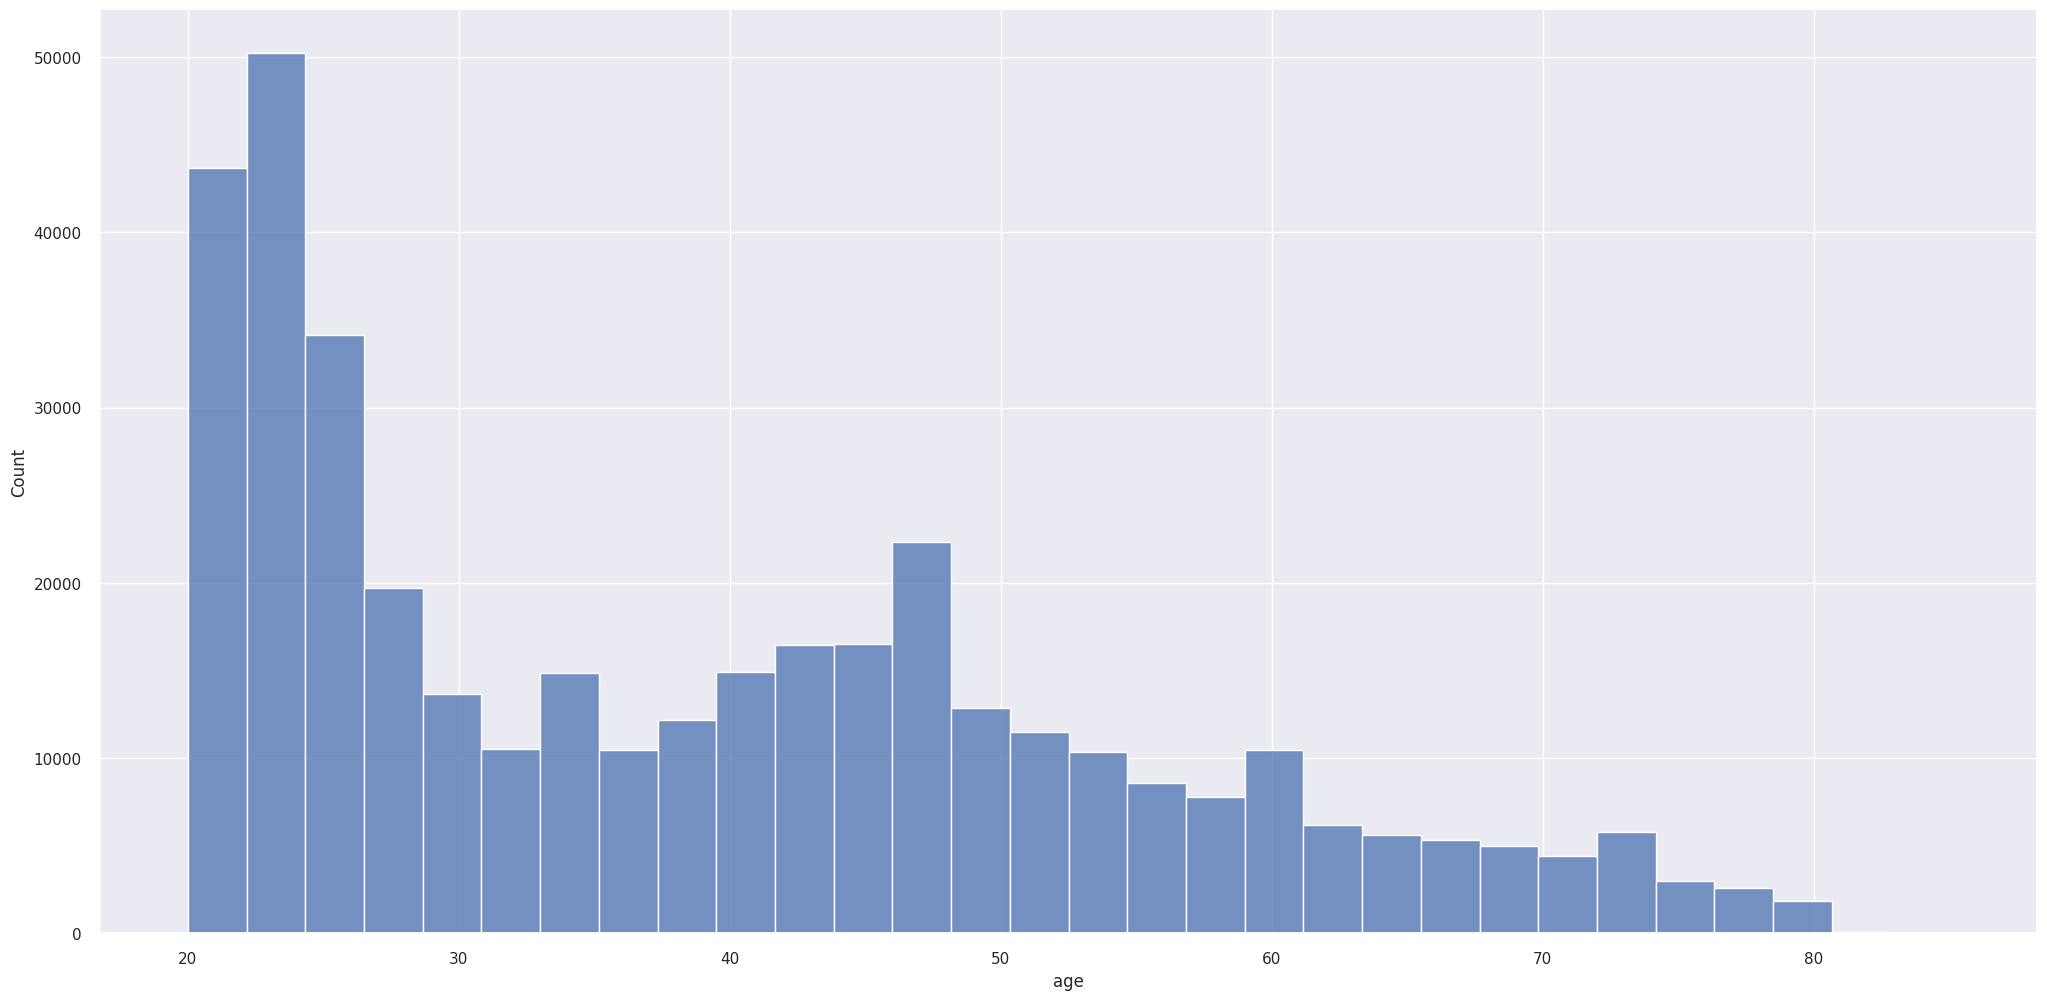

In [88]:
sns.histplot(df1['age'],bins=30);

## 1.7.1 CATEGORICAL ATTRIBUTES

In [89]:
#numbers of categorical attributes by feature
cat_attributes.apply(lambda x: x.unique().shape[0] )

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

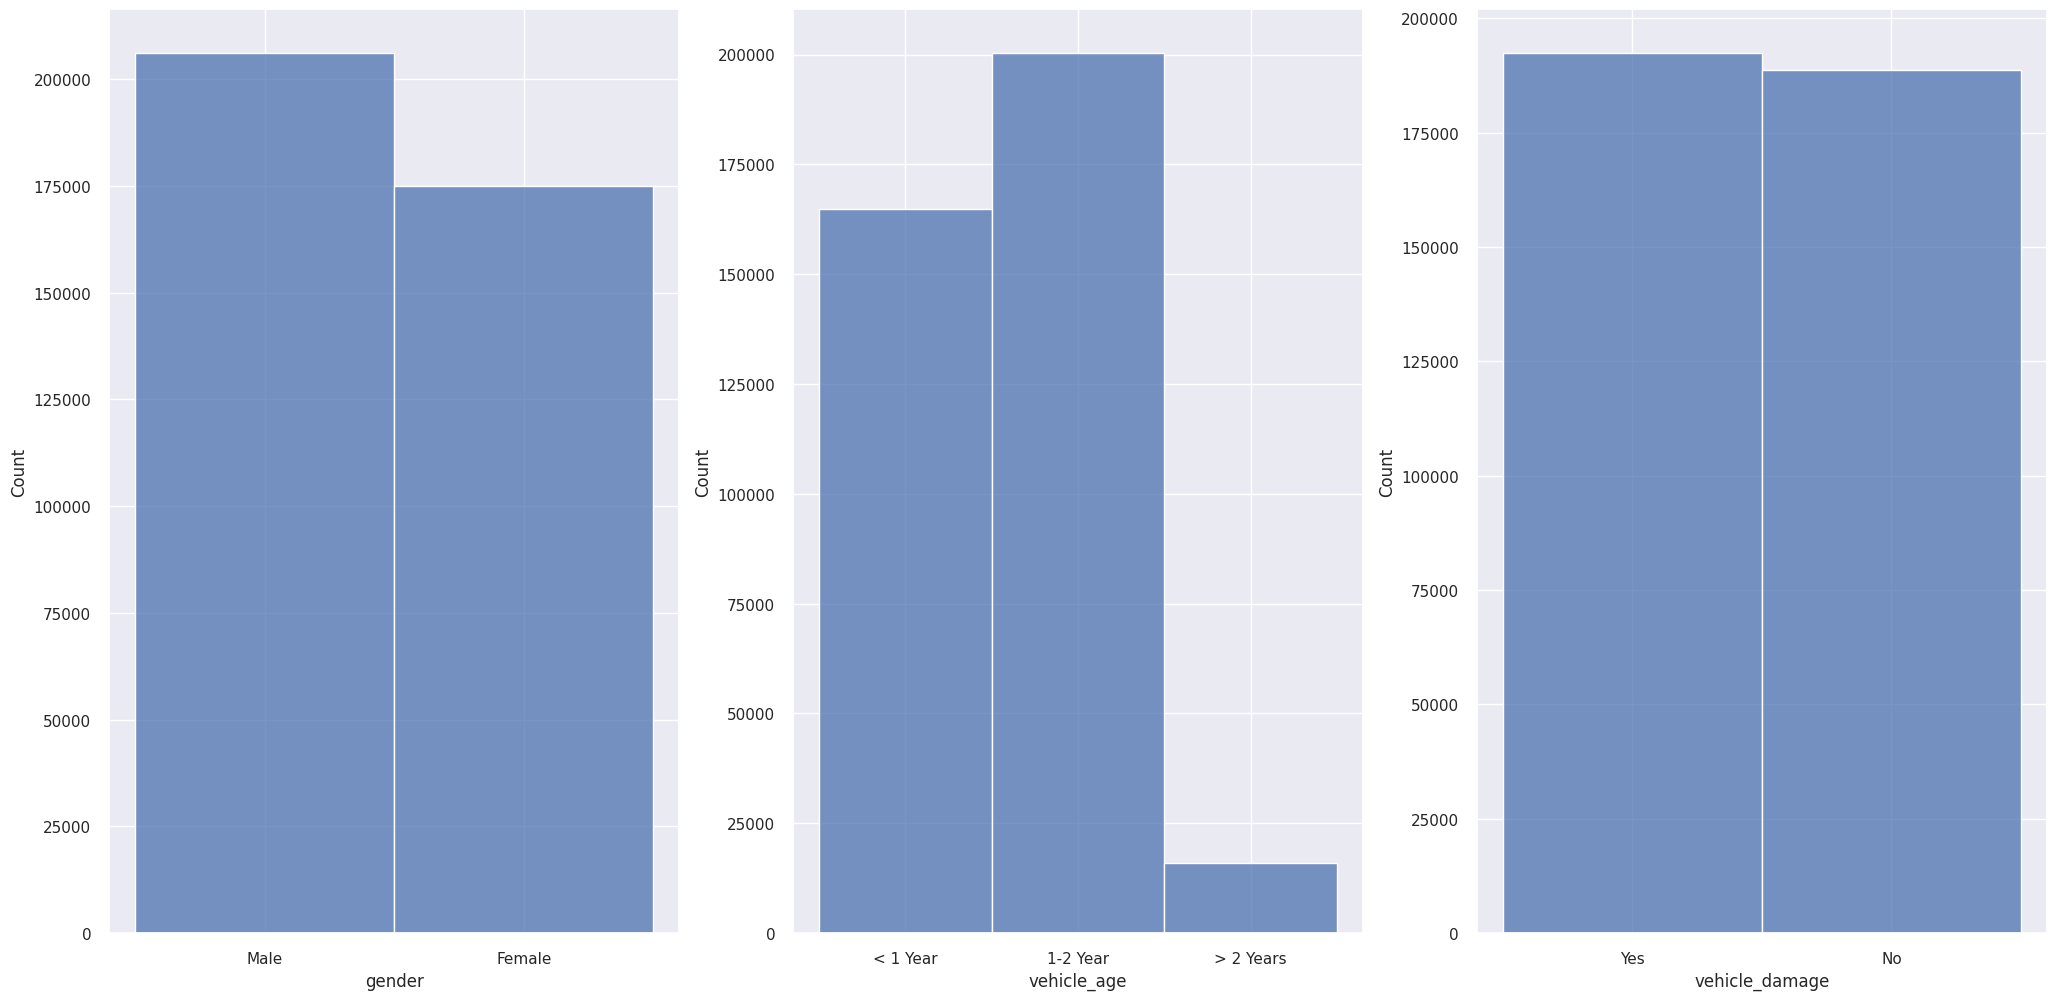

In [90]:
#plot of gender
plt.subplot(1,3,1)
sns.histplot(df1['gender'],bins=30);

#plot of vehicle age
plt.subplot(1,3,2)
sns.histplot(df1['vehicle_age'],bins=30);

#plot of vehicle damage
plt.subplot(1,3,3)
sns.histplot(df1['vehicle_damage'],bins=30);

# 2.0 FEATURE ENGINEERING

In [91]:
df2 = df1.copy(deep=True)

## 2.1 MIND MAP HPYOTHESIS

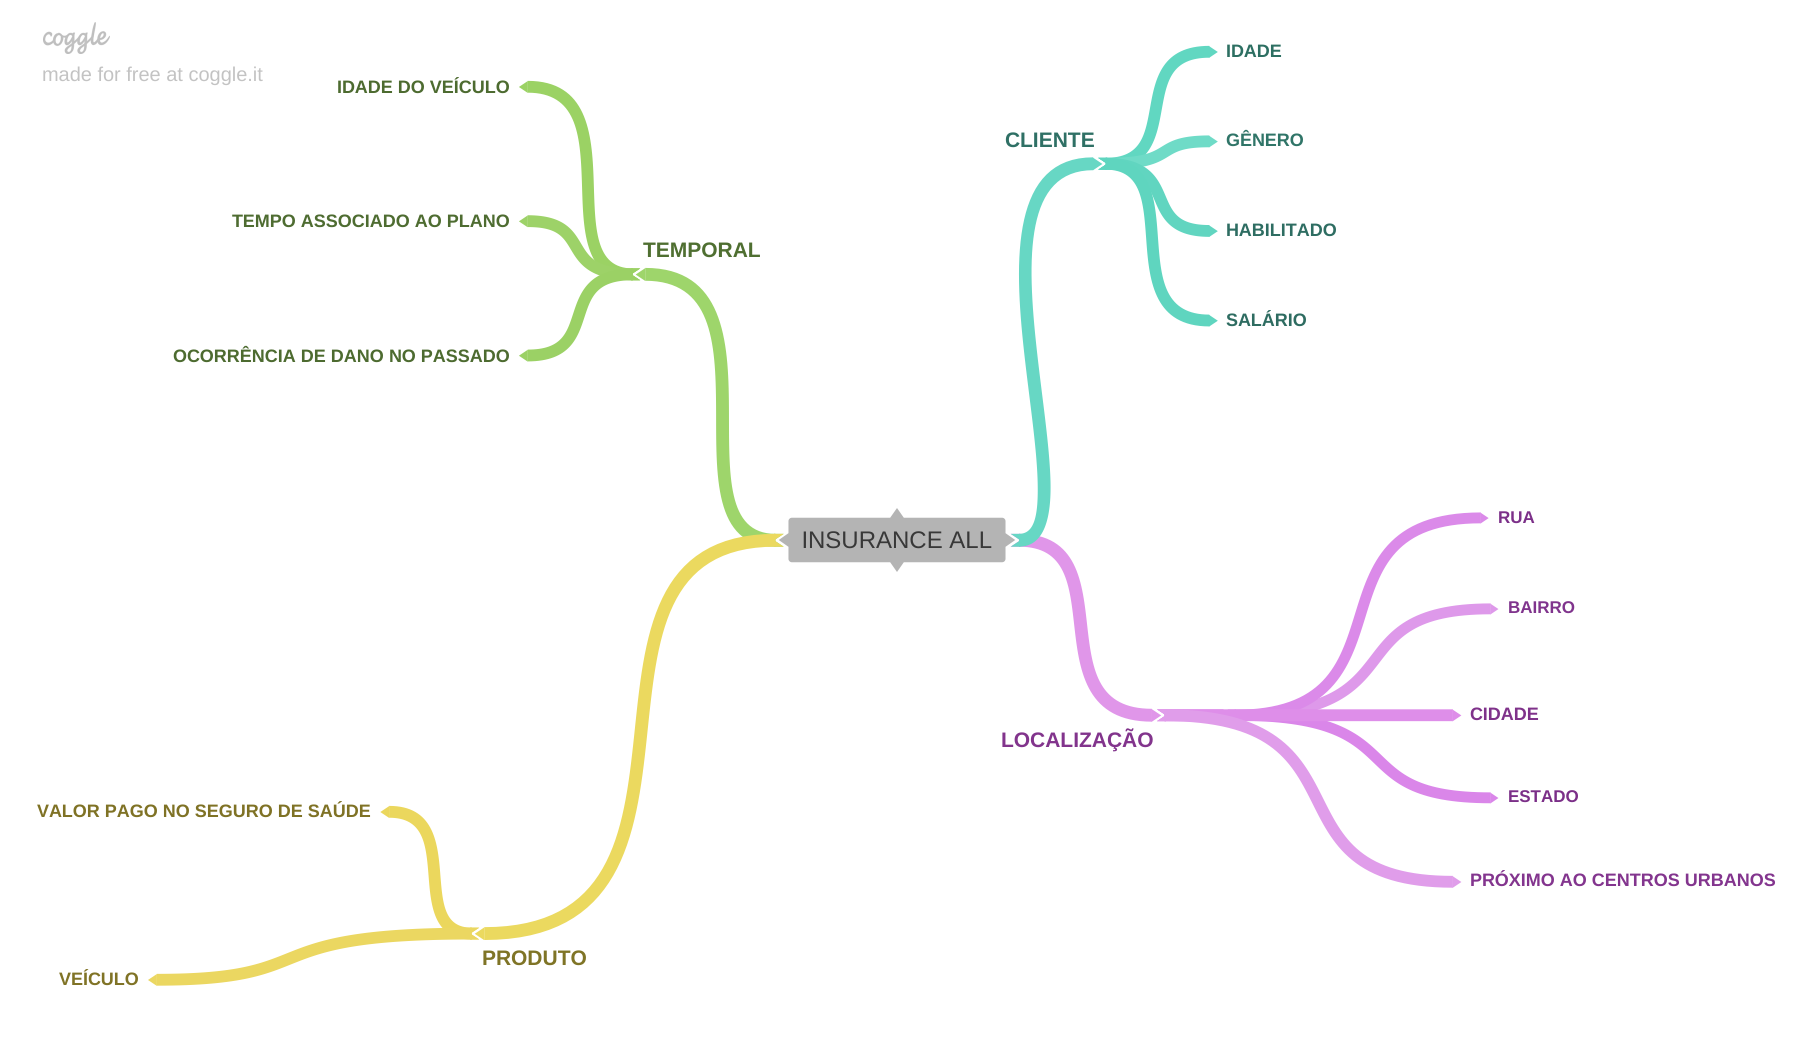

## 2.2 LIST HPYOTHESIS

## 2.3  HPYOTHESIS CUSTOMER

* Cliente mais velhos tem mais interesse em seguro automotivo

* Homens são mais habilitados do que mulheres

* Mulheres tem mais seguros automotivos do que homens

* Homens danificam mais os veículos do que mulheres

* Homens tem mais interesse em seguro veícular do que mulheres

* Homens possuem carros mais novos


## 2.4 HPYOTHESIS TEMPORAL

* O maior número de carros são de idade superior há 2 anos. 
* Pessoas que são mais tempo associadas ao plano de saúde contém mais seguro veícular. 
* Pessoas com mais tempo associada ao plano de saúde tem mais interesse ao seguro veícular.
* Carros mais velhos ocorrem mais danos.

## 2.5 HPYOTHESIS PRODUCT

* Pessoas que pagam mais pelo seguro de saúde tem menos interesse no seguro veícular
* Pessoas que pagam menos pelo seguro de saúde tem mais registros de danos no veículo
* Pessoas que pagam mais pelo seguro de saúde tem carros mais novos

## 2.6 LIST FINAL HPYOTHESIS 

**1** - Cliente mais velhos tem mais interesse em seguro automotivo

**2** - Homens são mais habilitados do que mulheres

**3** - Mulheres tem mais seguros automotivos do que homens

**4** - Homens danificam mais os veículos do que mulhereres.

**5** - Homens tem mais interesse em seguro veícular do que mulheres

**6** - Homens possuem carros mais novos

**7** -  O maior número de carros são de idade superior há 2 anos. 

**8** -  Pessoas com mais tempo associada ao plano de saúde tem mais interesse ao seguro veícular.

**9** -  Carros mais antigos ocorrem mais danos.

**10** - Pessoas que pagam mais pelo seguro de saúde tem menos interesse no seguro veícular

**11** - Pessoas que pagam menos pelo seguro de saúde tem mais registros de danos no veículo

**12** - Pessoas que pagam mais pelo seguro de saúde tem carros mais novos

## 2.7 FEATURE ENGERING

In [92]:
#rename the rows of colum vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 0 if x== '< 1 Year' 
                                              else 2 if x== '1-2 Year'
                                              else 3 
                                              if x== '> 2 Years' else x)

#rename the rows of colum vehicle damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 0 if x=='No' else 1)

#convent the days in month
df2['vintage'] = df2['vintage'].apply(lambda x: x/30)

#convent the colum to type int
df2['vintage'] = df2['vintage'].astype('int')

# 3 - FILTERING THE DATA

### 3.1 - SELECT THE COLUMNS

# 4- Exploratory DATA ANALYSIS

In [93]:
df4 = df2.copy(deep=True)

## 4.1 ANALSY  UNIVARIABLE THE RESPONSE VARIABLE 

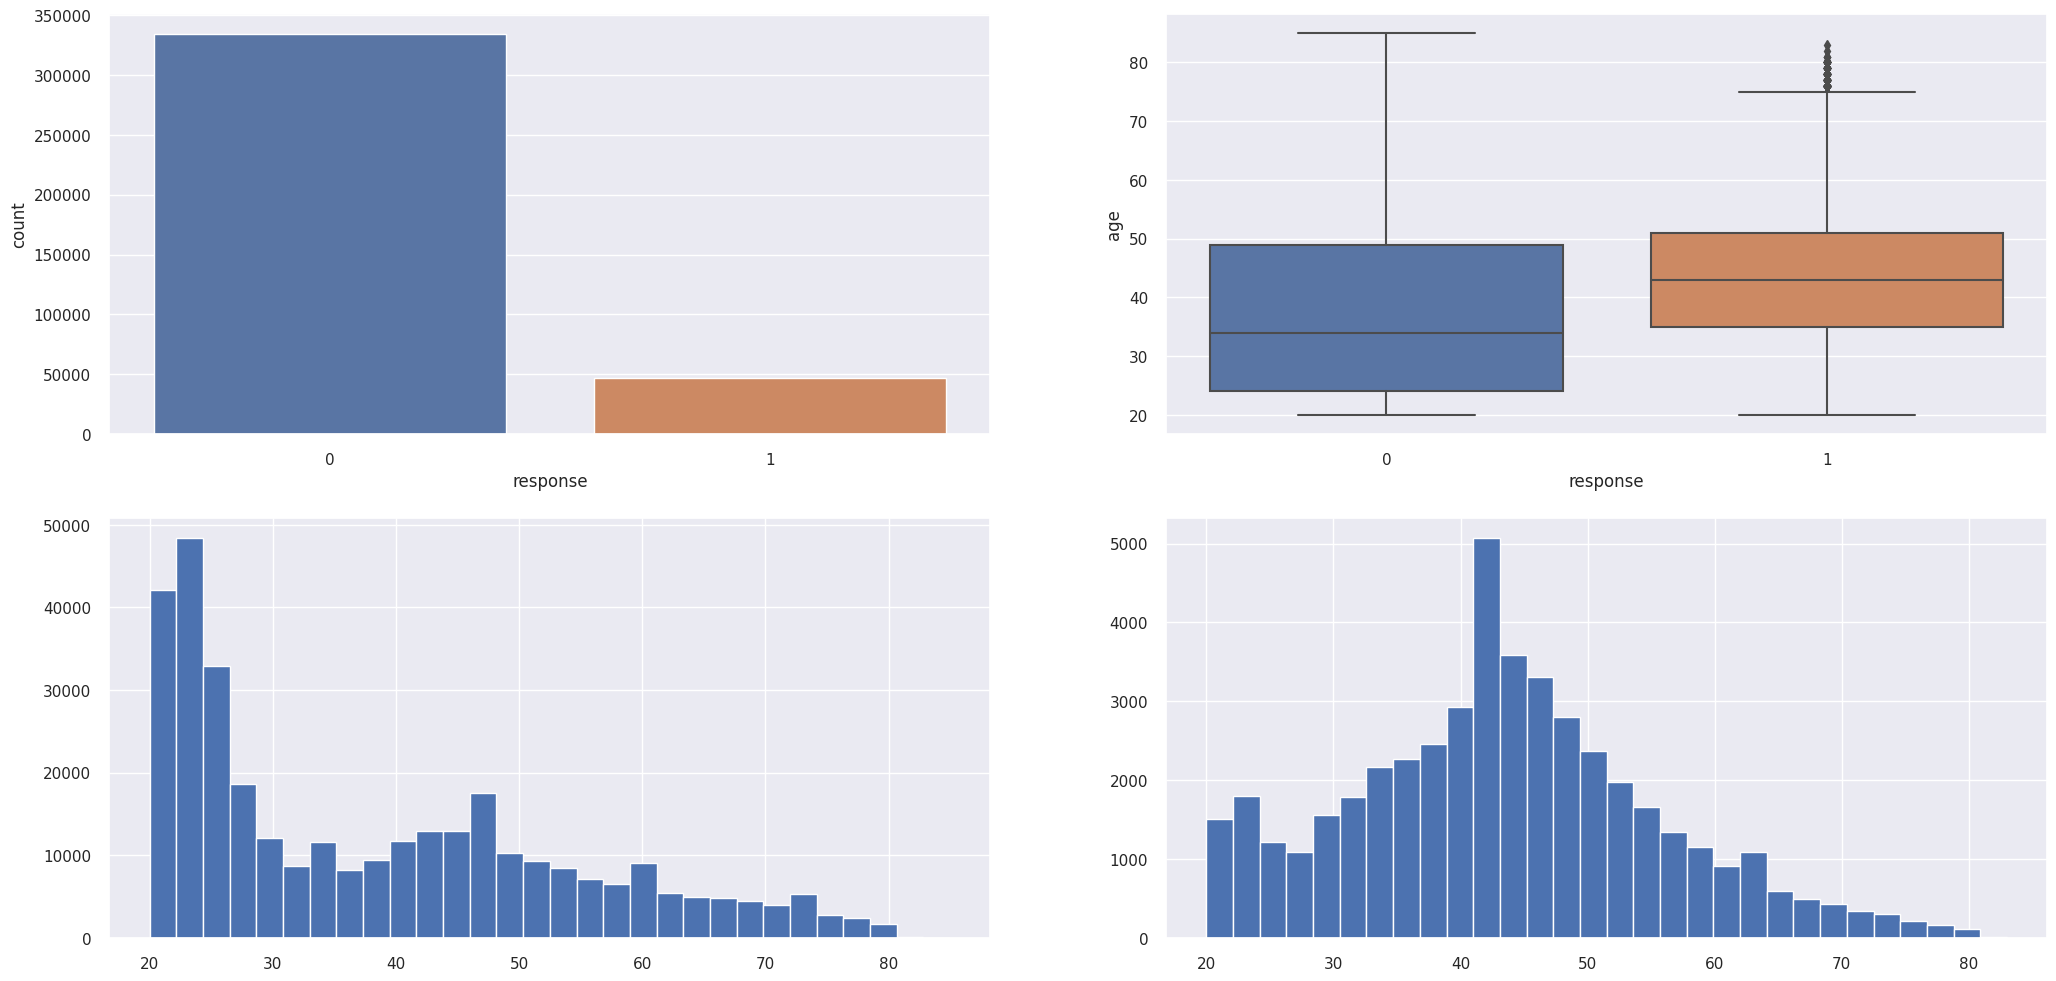

In [94]:
#plot the response variable with total of people interest and not interest
plt.subplot(2,2,1)
sns.countplot(x= 'response', data= df4);

#plot of featarue response in between the age
plt.subplot(2,2,2)
sns.boxplot(x ='response', y='age', data= df4);

#plot only the people not interest 
plt.subplot(2,2,3)
aux00 = df4.loc[df4['response']==0, 'age' ]
aux00.hist(bins=30);

#plot only the people interest
plt.subplot(2,2,4)
aux00 = df4.loc[df4['response']==1, 'age' ]
aux00.hist(bins=30);

## 4.2 - ANALSY NUMERIC  

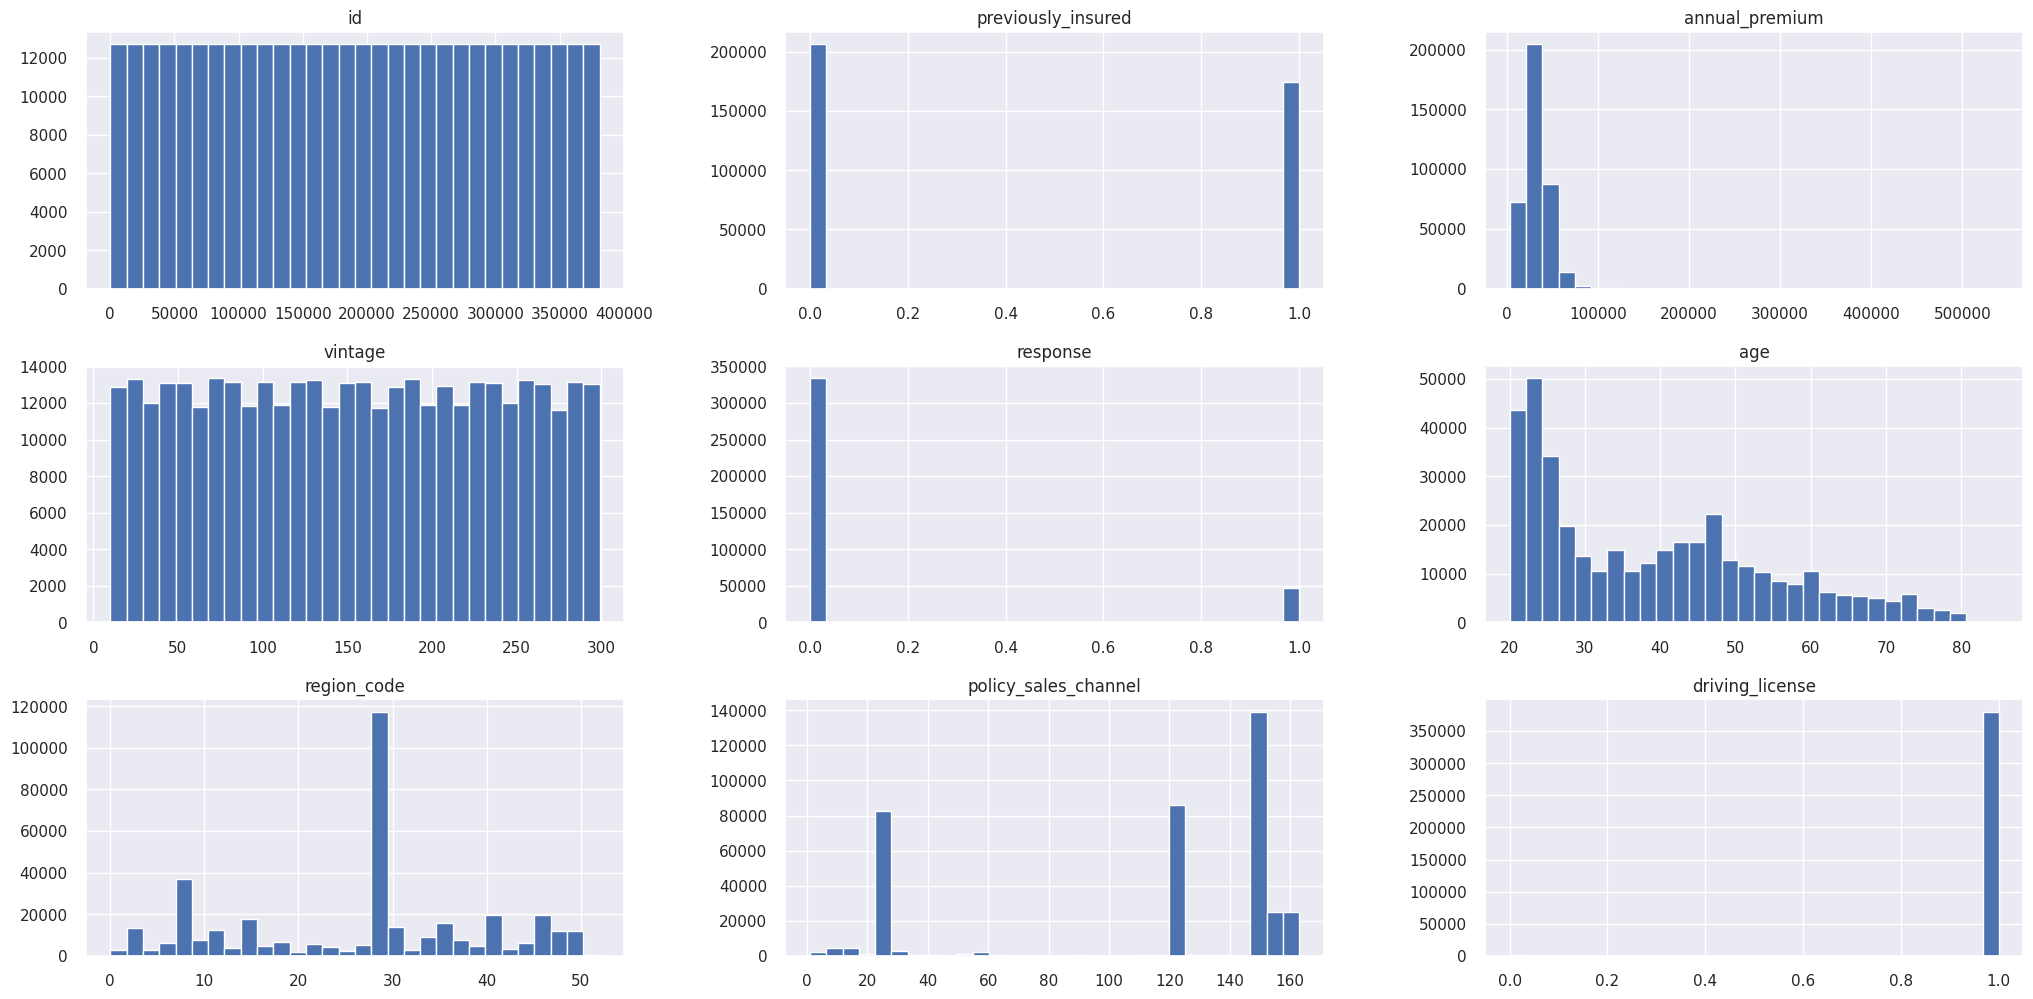

In [95]:
num_attributes.hist(bins=30);

## 4.3 ANALSY CATEGORICAL 

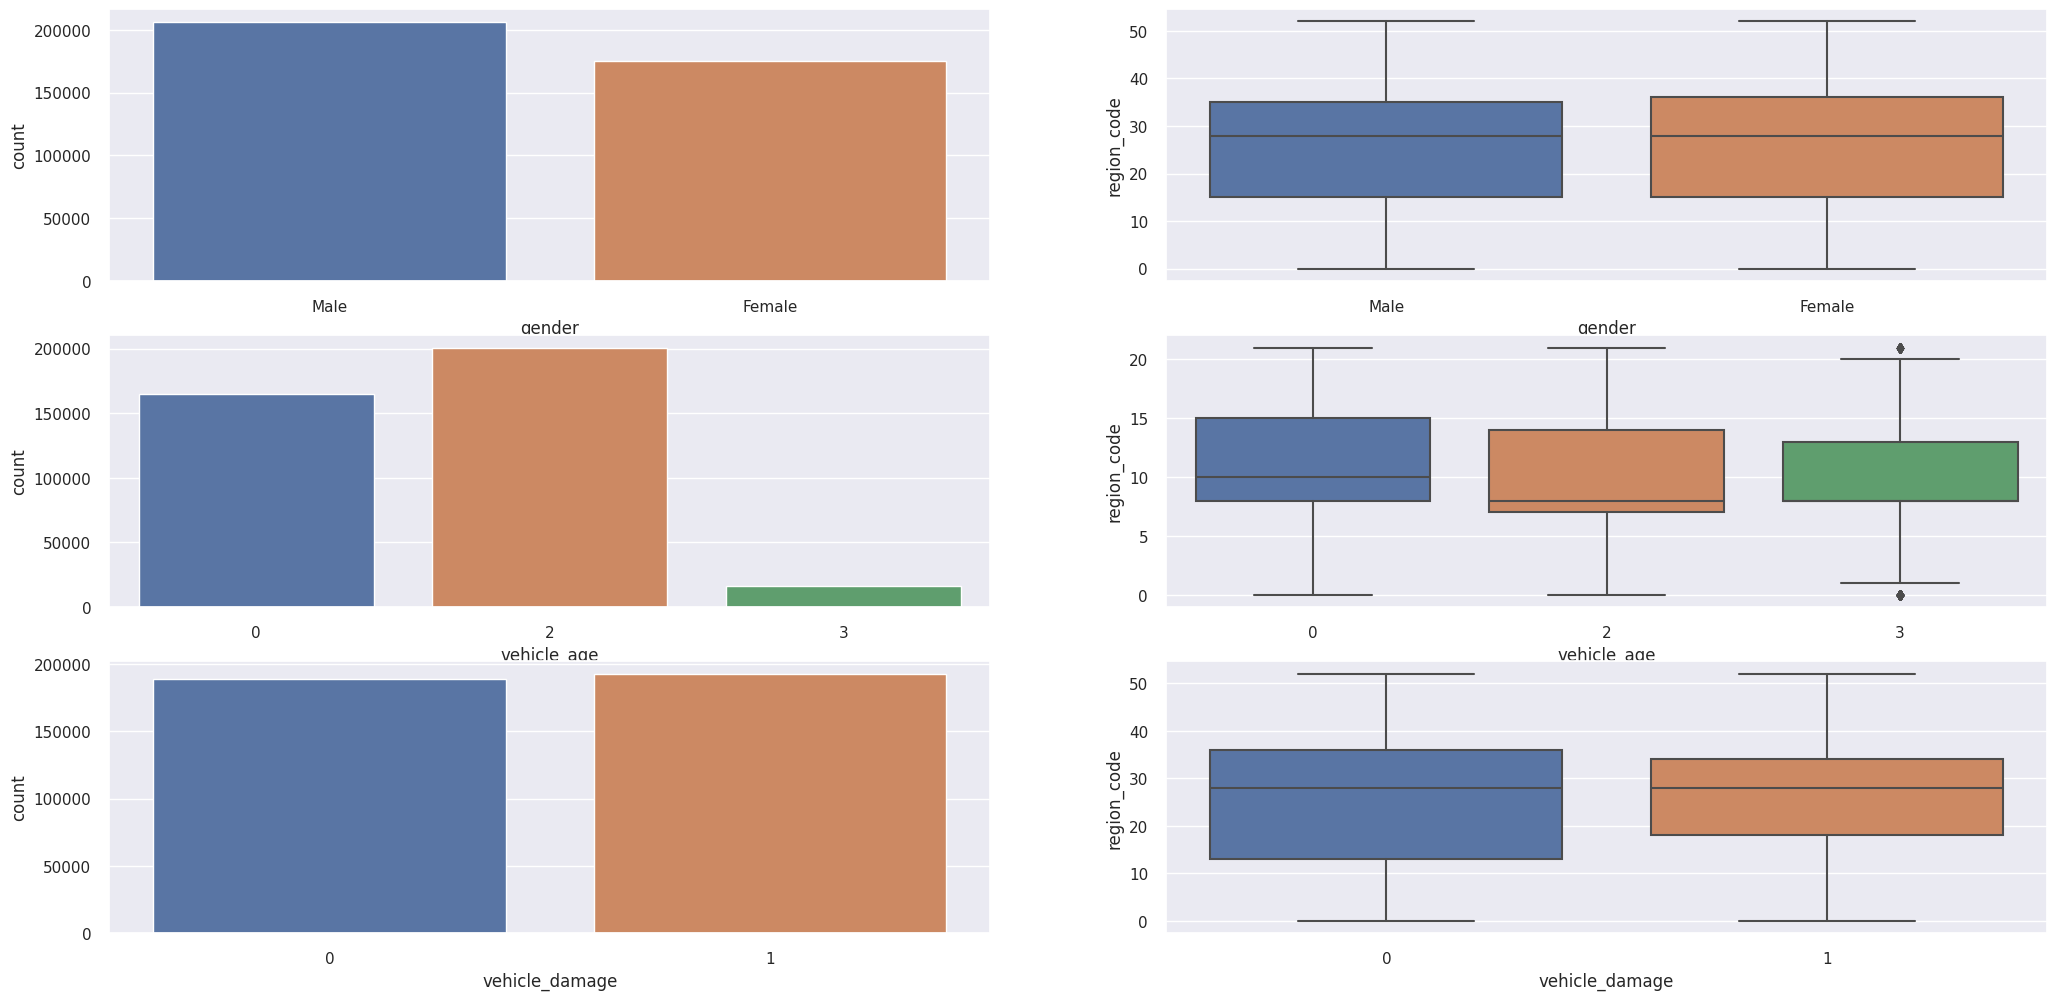

In [96]:
##### ============================== gender ============================== ###

#plot of total gender
plt.subplot(3,2,1)
sns.countplot(x = 'gender', data = df4);

#pltol boxplot of gender in between region code
plt.subplot(3,2,2)
sns.boxplot(x = 'gender', y = 'region_code', data= df4);

##### ============================== vehicle age ============================== ###
#plot total vehichle age
plt.subplot(3,2,3)
sns.countplot(x = 'vehicle_age', data = df4);


#filter the vehicle age with region code less than 22
aux_vehicle_age = df4.loc[df4['region_code']< 22]

#plot boxplot of vehicle age  between region code
plt.subplot(3,2,4)
sns.boxplot(x = 'vehicle_age', y = 'region_code', data = aux_vehicle_age);

##### ============================== vehicle damage ============================== ###

#plot of total vehicle damage
plt.subplot(3,2,5)
sns.countplot(x = 'vehicle_damage', data=df4);

plt.subplot(3,2,6)
#plot boxplot of vehicle damage in between region code
sns.boxplot(x = 'vehicle_damage', y = 'region_code', data=df4);

## 4.4 ANALSY BIVARIABLE

### H1 - Clientes acima de 40 anos tem mais interesse em seguro automotivo.

**Verdadeira:** Clientes acima de 40 anos tem mais interesse em seguro veícular. .

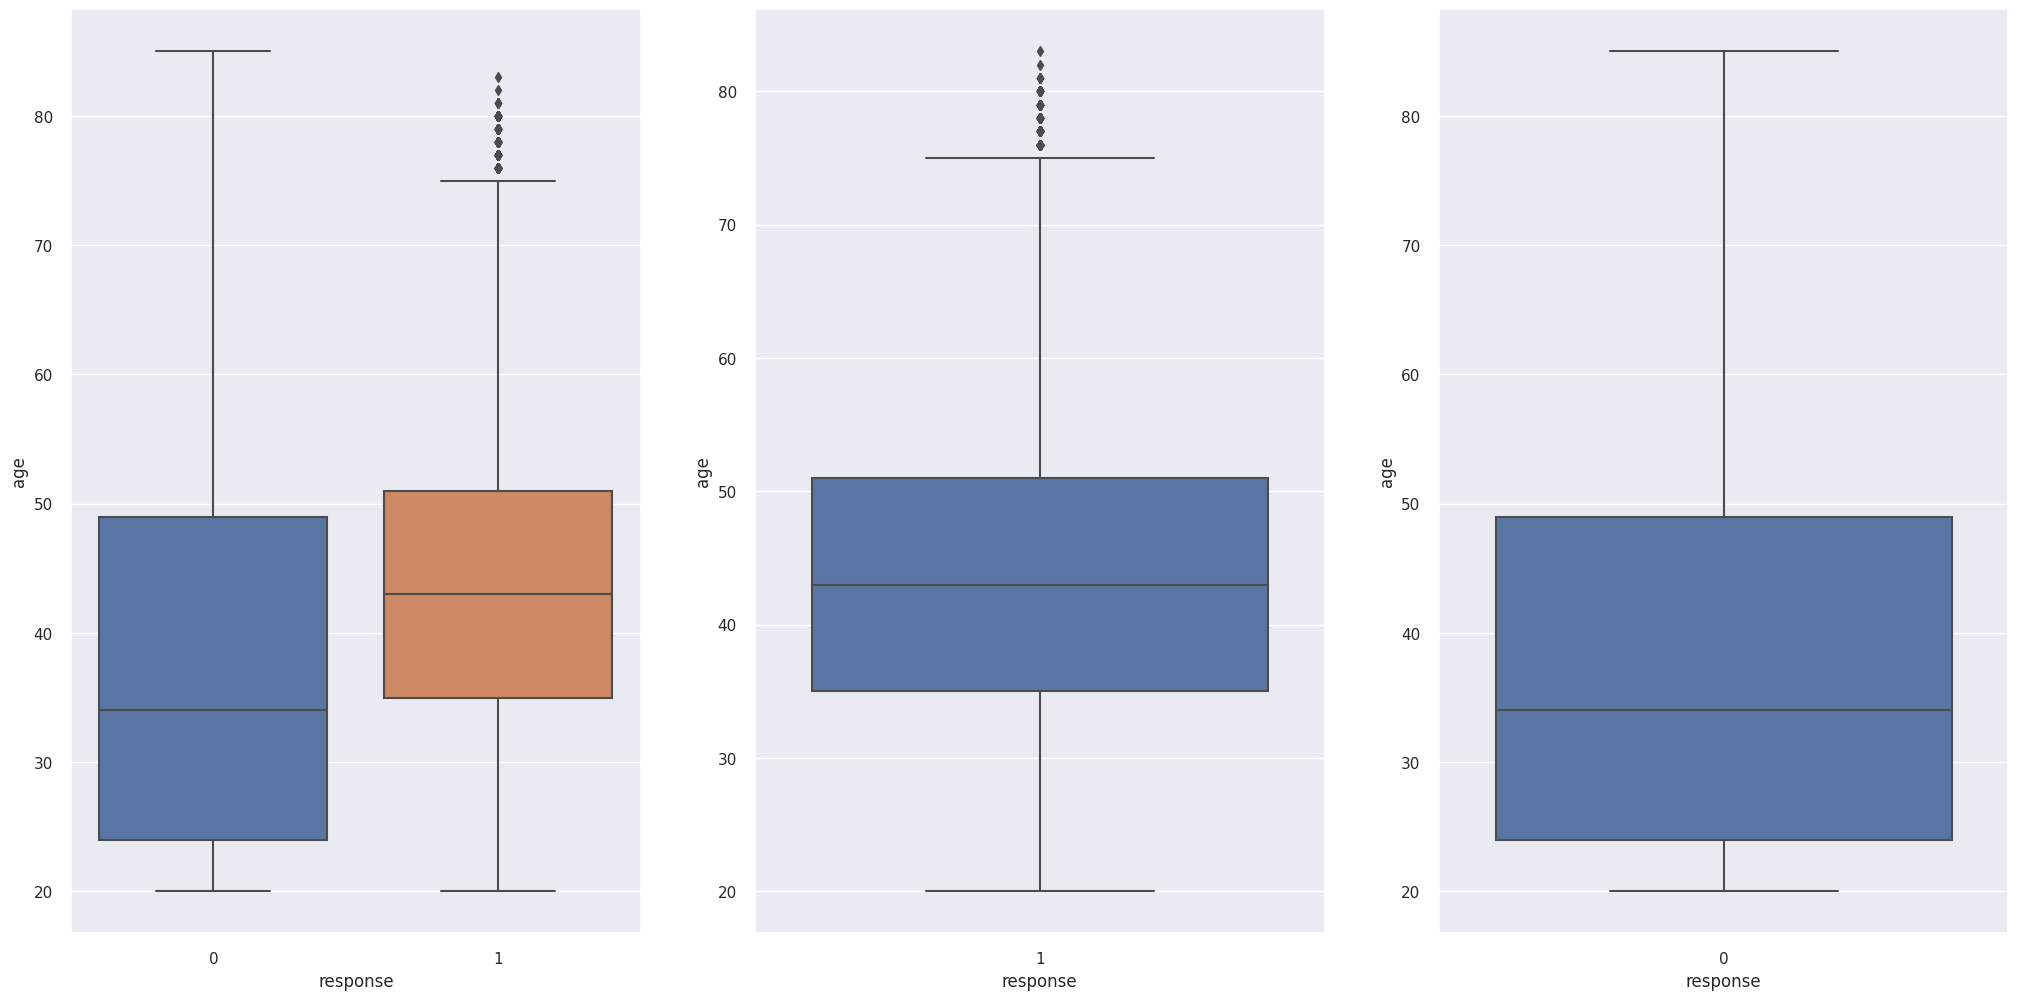

In [97]:
#collecting the columns necessary
auxh1= df4[['age','response']].copy(deep=True)

#plot of boxplot
plt.subplot(1,3,1)
sns.boxplot(x = 'response', y ='age', data= auxh1);

# ======

plt.subplot(1,3,2)
#filter the people that has interest
has_interest = auxh1.loc[auxh1['response']==1]

#plot boxplot of people above of 40 year has interest
sns.boxplot(x='response', y= 'age', data= has_interest);

# ========
plt.subplot(1,3,3)
#filter the people not has interest
not_has_interest = auxh1.loc[auxh1['response']==0]

#plot boxplot of people above of 40 year not has interest
sns.boxplot(x='response', y='age', data=not_has_interest);



### H2 - Homens são mais habilitados do que mulheres.

**Verdadeira:** Homens são mais habilitados do que mulheres 

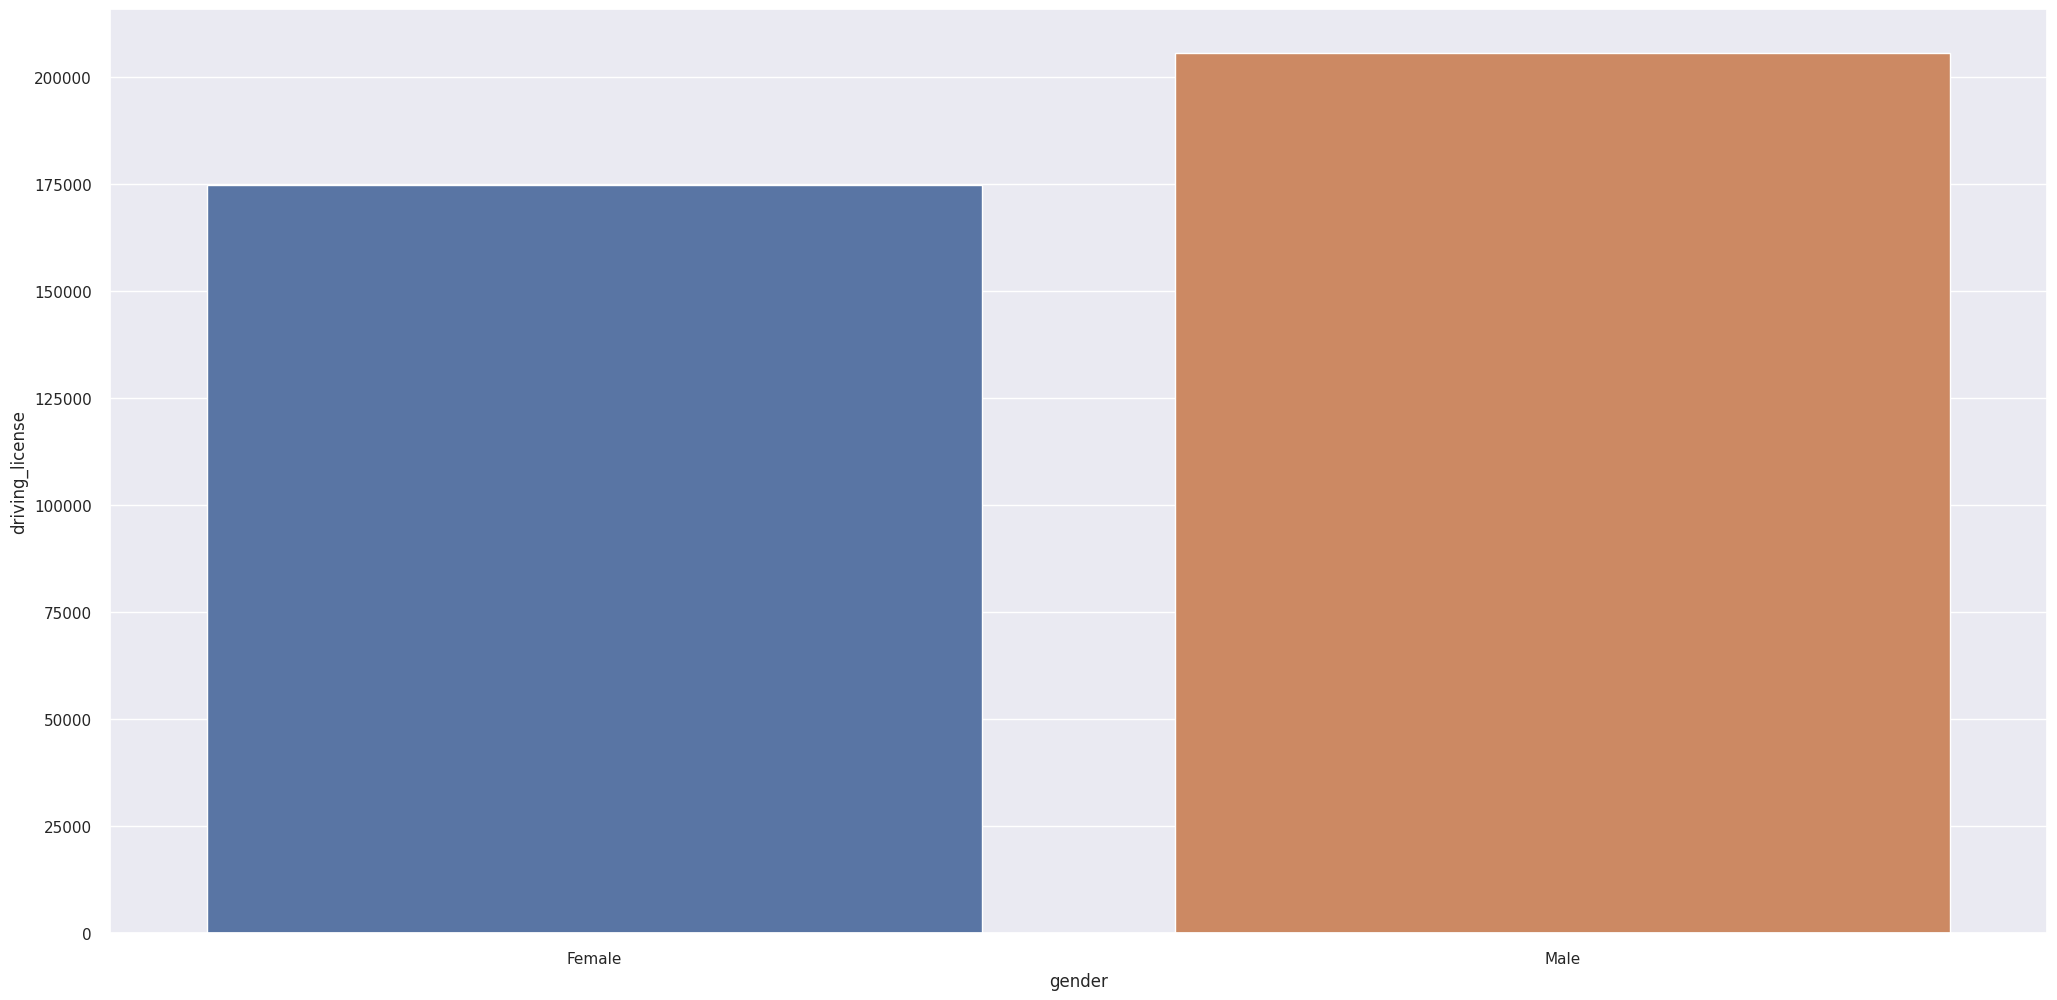

In [98]:
#select the columns necessary
auxh2 = df4[['gender','driving_license']]

#filtering the data with the people that has driving license
aux_license = auxh2.loc[auxh2['driving_license']==1]

#group of the gender with driving license
aux_h2 = aux_license[['gender','driving_license']].groupby('gender').count().reset_index()

#plot of comparation
sns.barplot(x = 'gender', y='driving_license', data= aux_h2);



### H3 - Mulheres tem mais seguros automotivos do que homens.
**Verdadeira:** Mulheres tem mais seguros de veículos do que homens

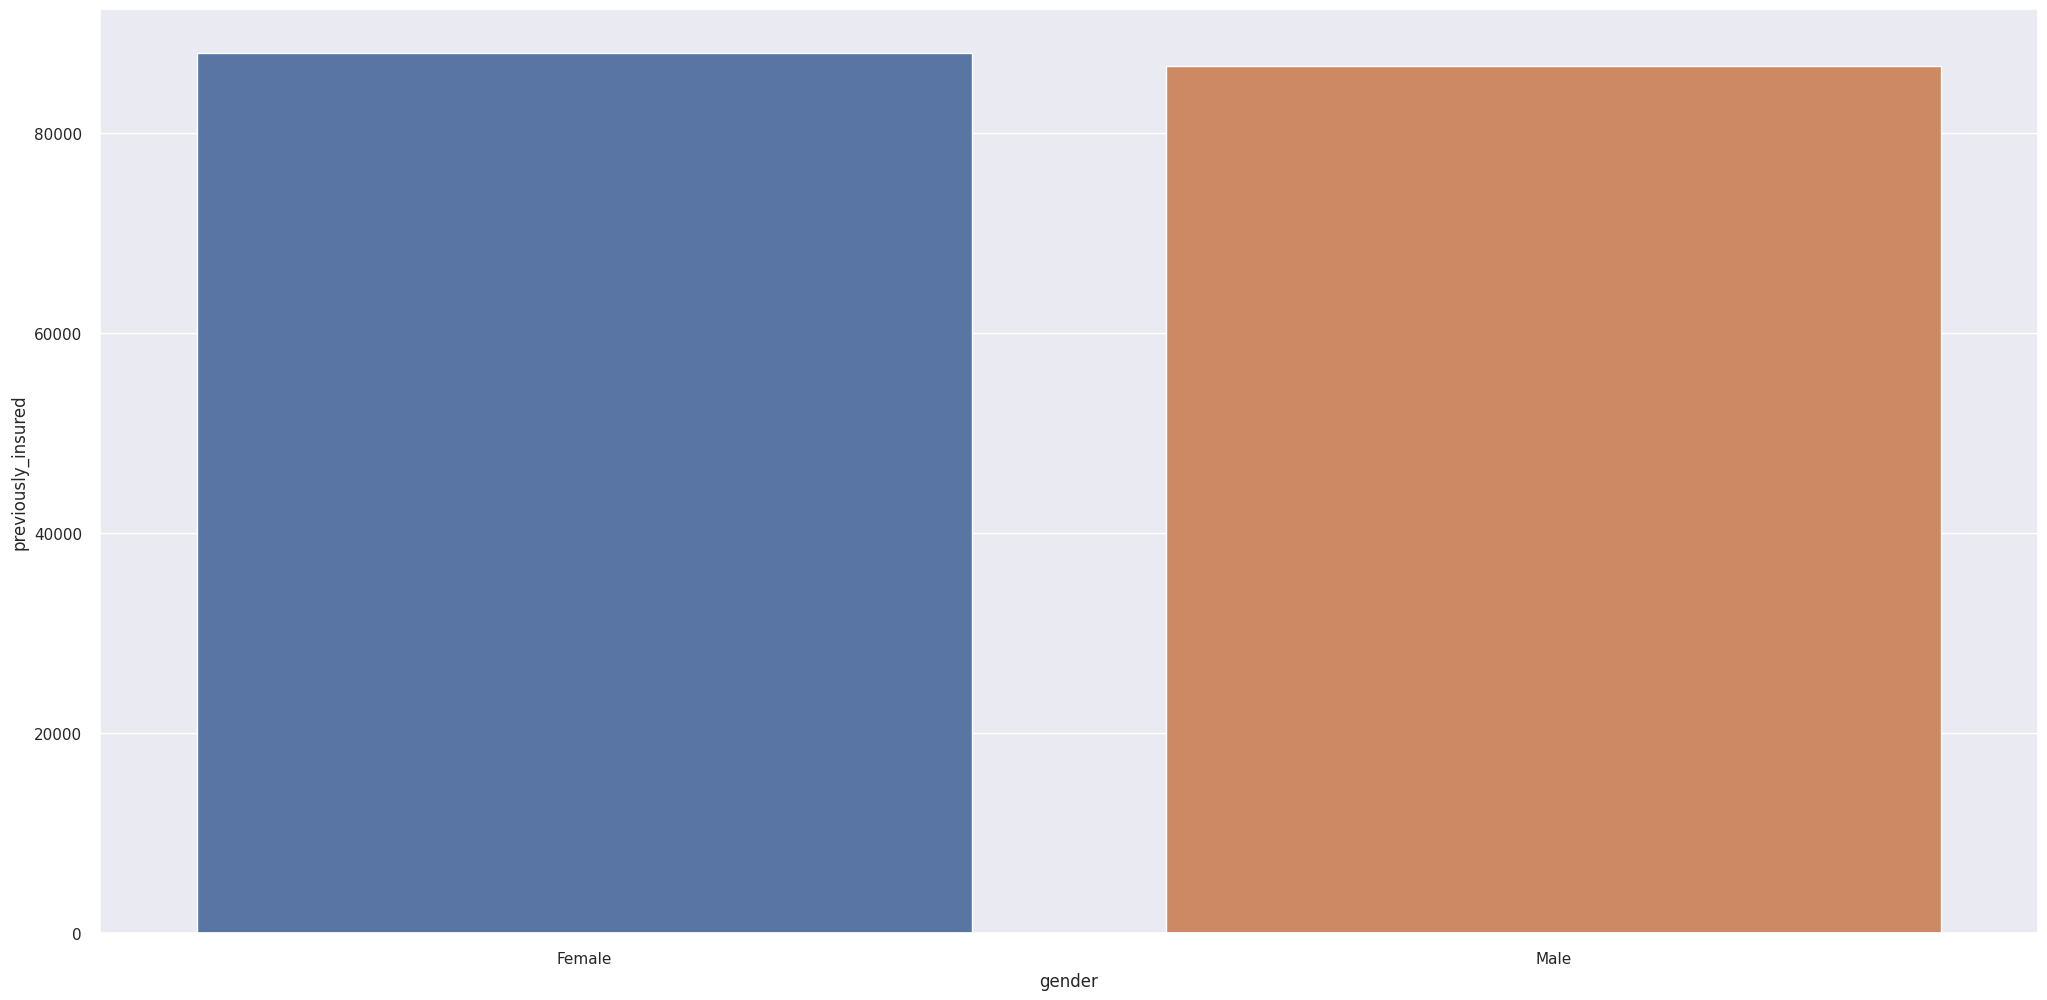

In [99]:
auxh3 = df4[['gender','previously_insured']]

aux_insured = auxh3.loc[auxh3['previously_insured']==1]

aux_h3 = aux_insured[['gender','previously_insured']].groupby('gender').count().reset_index()

sns.barplot(x ='gender',y= 'previously_insured',data=aux_h3);

### H4 - Homens danificam mais os veículos do que mulheres.

**Verdadeira:** Homens danificam mais os veículos do que mulheres

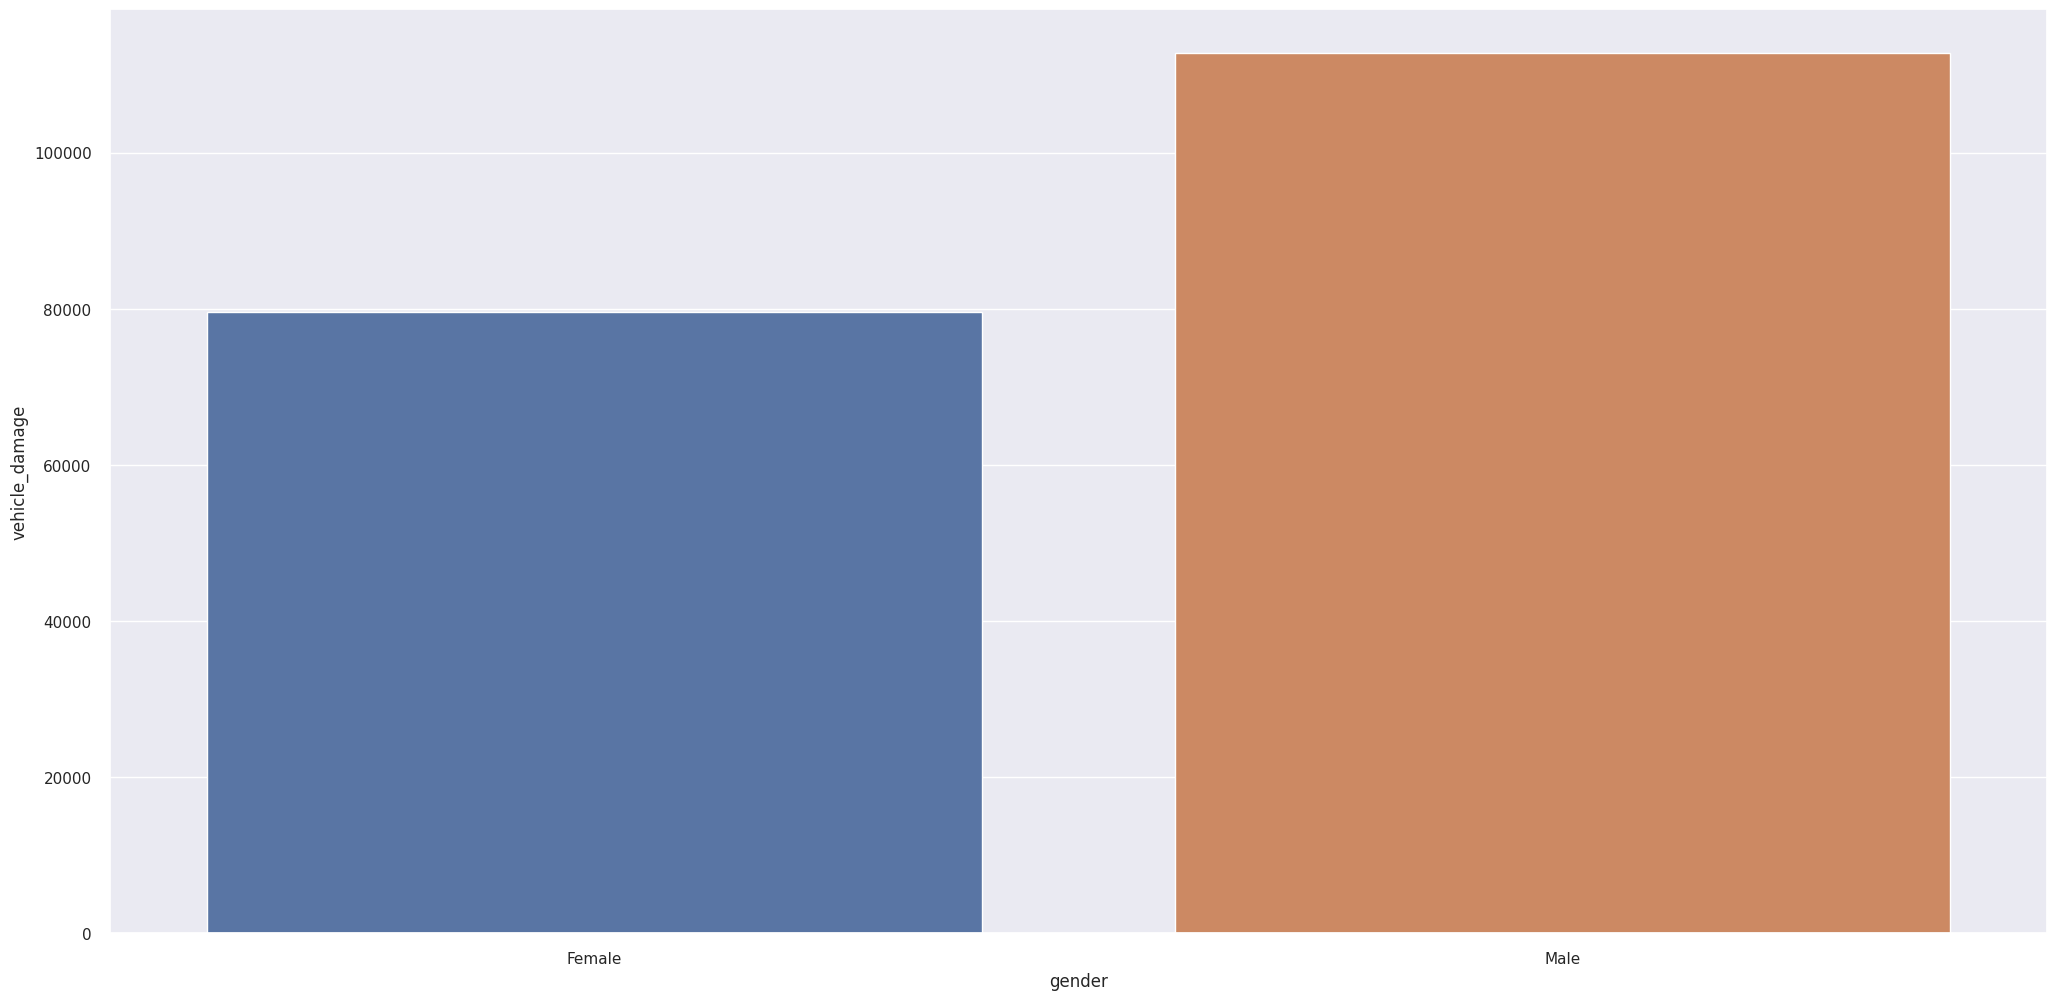

In [100]:
#select the columns necessary
auxh4 = df4[['gender','vehicle_damage']]

#filtering the people that the vehicle had damage
aux_damage = auxh4.loc[auxh4['vehicle_damage']==1]

aux_h4 = aux_damage[['gender','vehicle_damage']].groupby('gender').count().reset_index()

sns.barplot( x = 'gender', y = 'vehicle_damage', data= aux_h4);

### H5 - Homens tem mais interesse em seguro veícular do que mulheres
**Verdadeira:** Homens tem mais interesse em seguro veícular do que mulheres

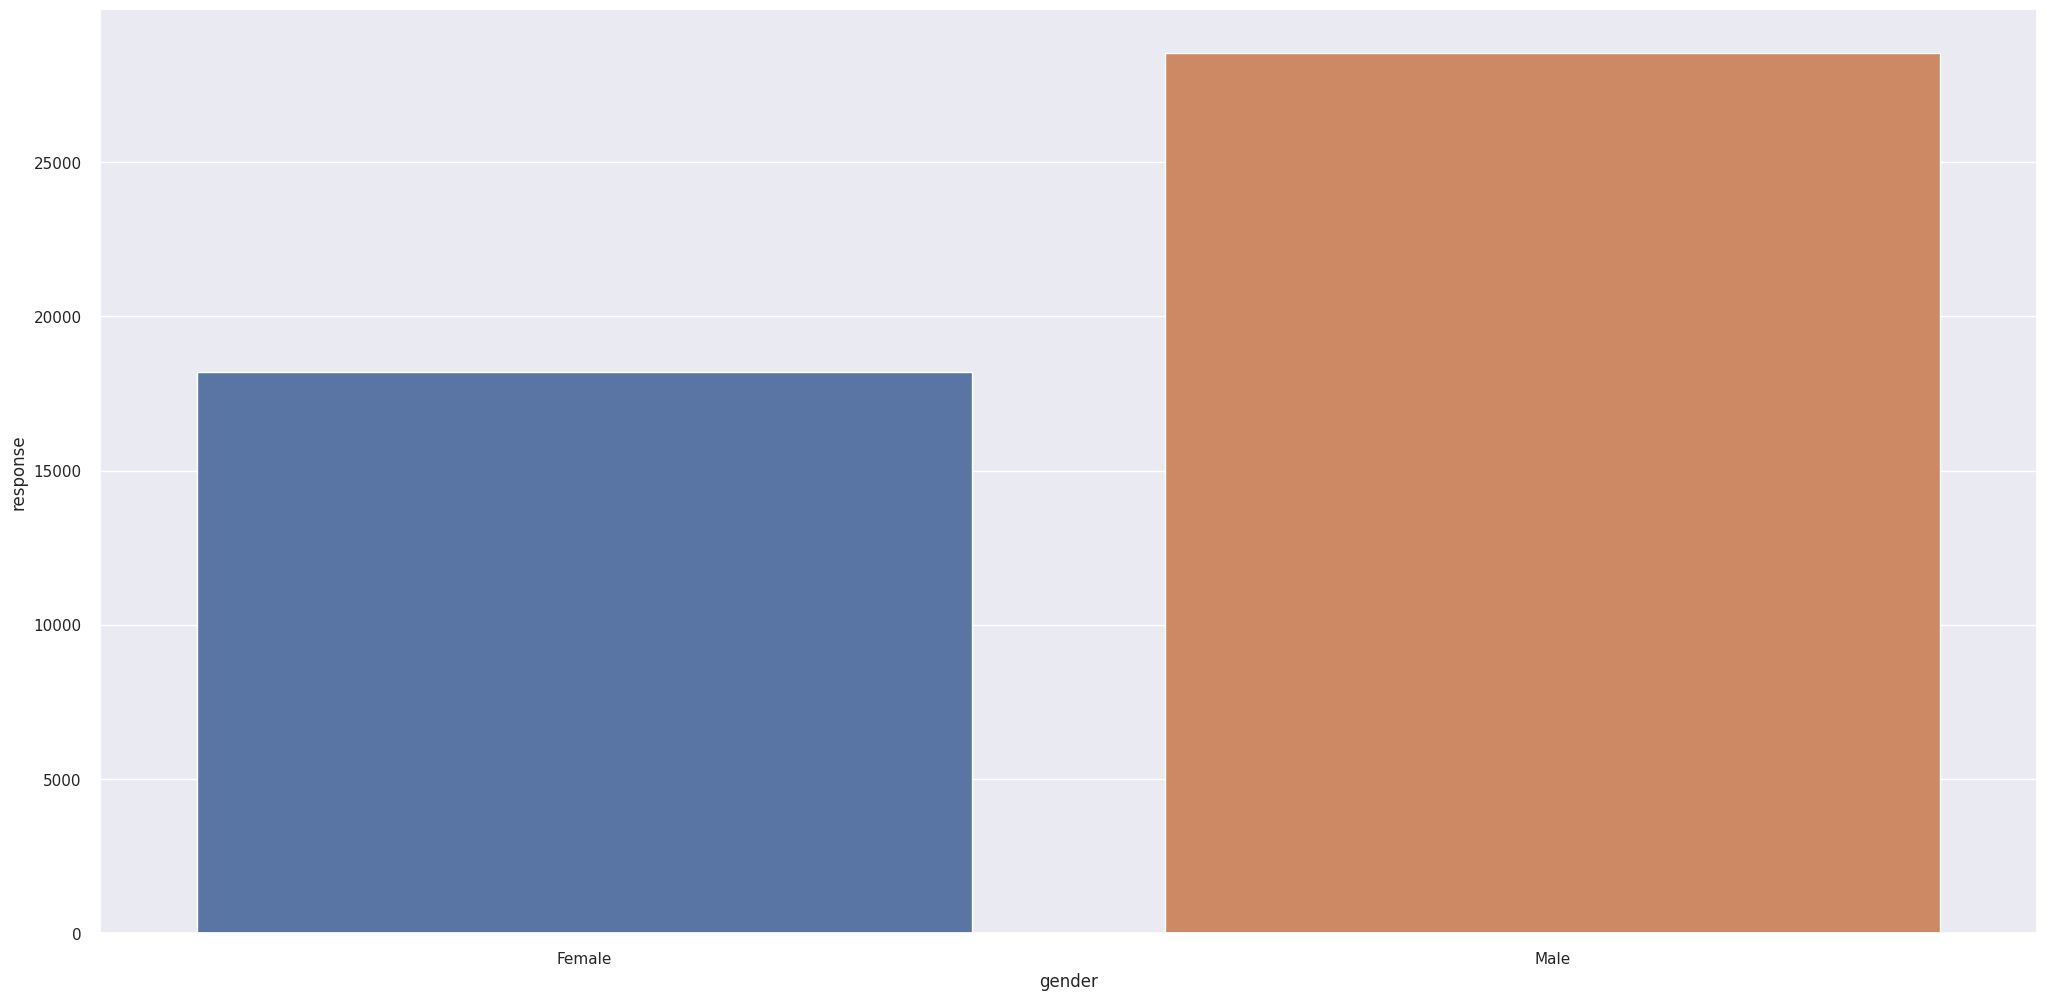

In [101]:
auxh5 = df4[['gender','response']]

aux_interest_insured = auxh5.loc[auxh5['response']==1]

aux_h5 = aux_interest_insured[['gender','response']].groupby('gender').count().reset_index()

sns.barplot(x ='gender', y = 'response', data = aux_h5);

### H6 - Homens possuem carros mais novos
**Verdadeira:** Homens possuem carros mais novos

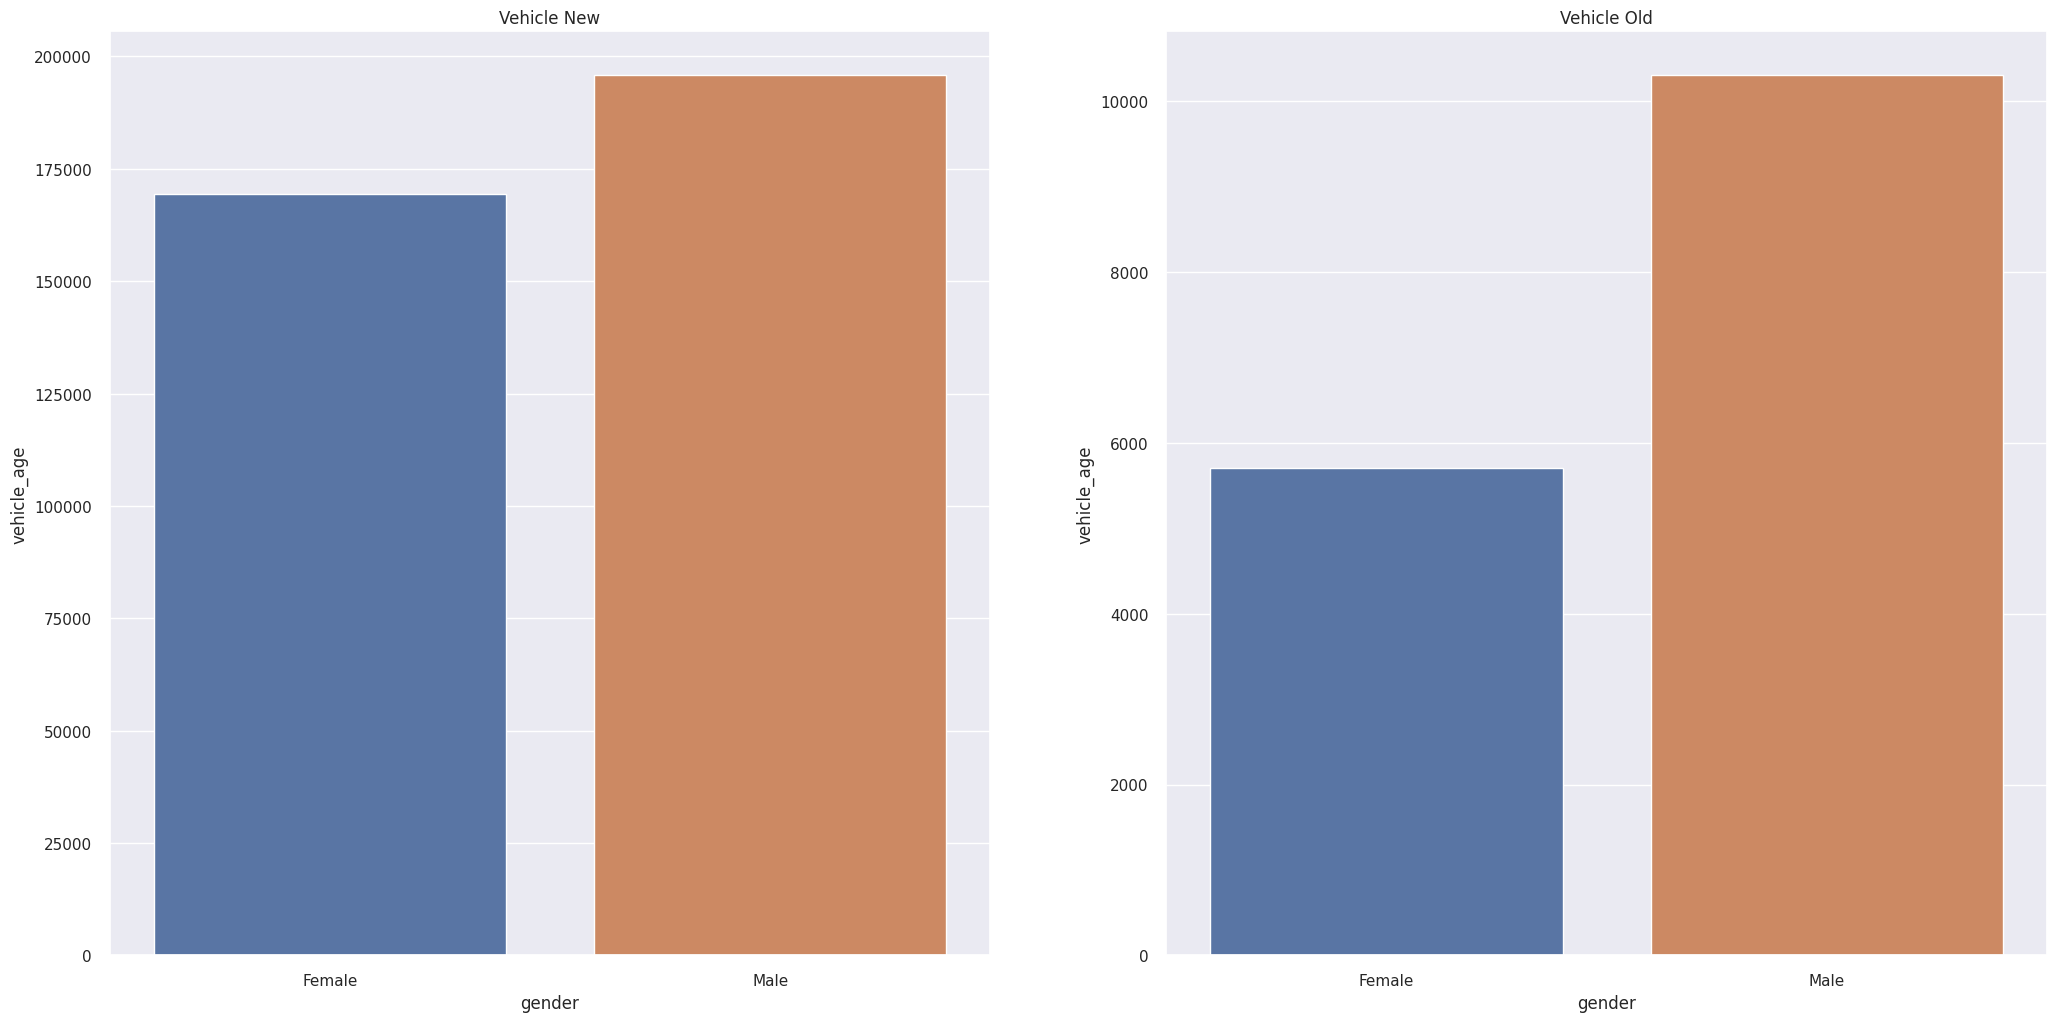

In [102]:
#select the columns
auxh6 = df4[['gender','vehicle_age']]

#filter the vehicle age
filter_new_vehicle = auxh6.loc[auxh6['vehicle_age']<3]

#group the vehicle age
aux_new = filter_new_vehicle[['gender','vehicle_age']].groupby('gender').count().reset_index()

#plot new vehicle 
plt.subplot(1,2,1)
sns.barplot(x ='gender', y='vehicle_age', data= aux_new)
plt.title('Vehicle New');

#filter the old vehicle age
filter_old_vehicle = auxh6.loc[auxh6['vehicle_age']>=3]

#group the old vehicle age
aux_old = aux_h6 = filter_old_vehicle[['gender','vehicle_age']].groupby('gender').count().reset_index()

#plot the old vehicle
plt.subplot(1,2,2)
sns.barplot(x='gender', y='vehicle_age', data= aux_old);
plt.title('Vehicle Old');


### H7 - O maior número de pessoas interessadas são pessoas com veículos com idade superior há 2 anos.
**Falso:** O maior número de pessoas interessadas, são as pessoas com veículo com idade entre 1 e 2 anos



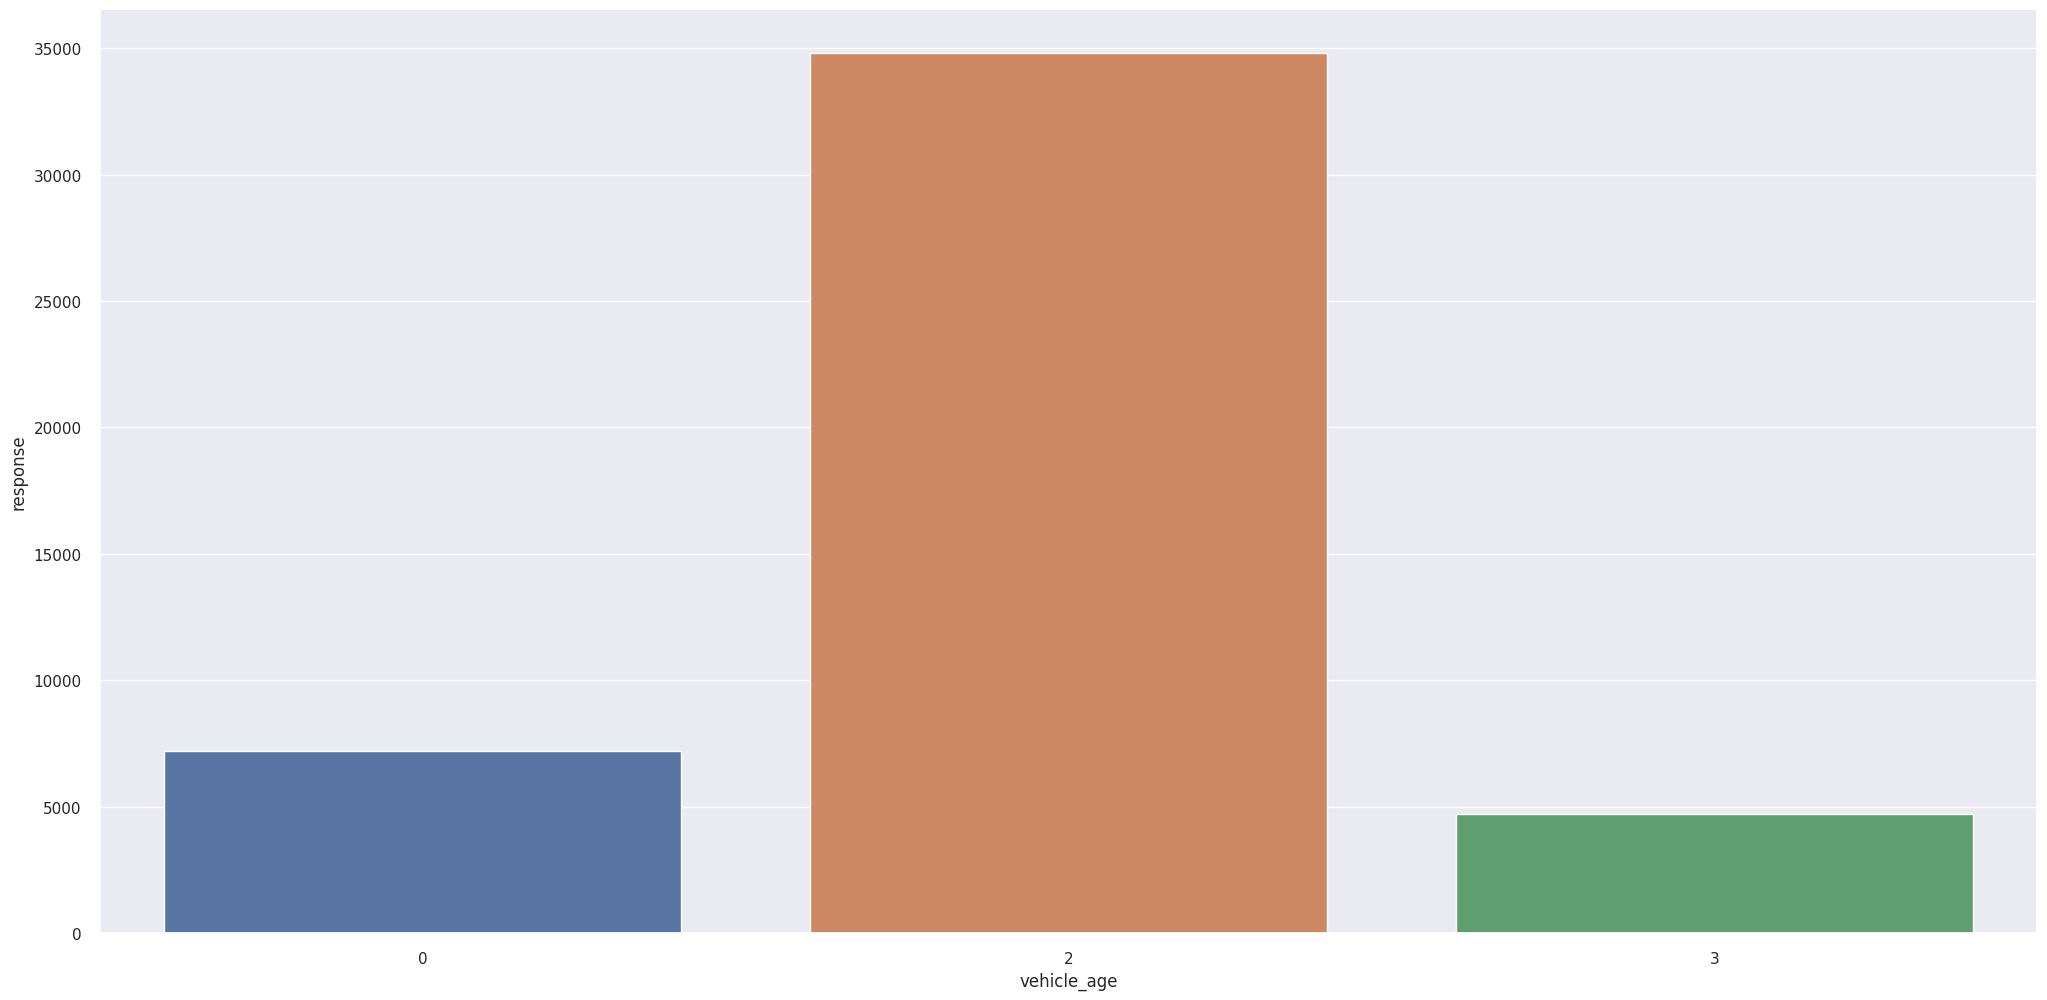

In [103]:
#select the columns necessary
auxh7 = df4[['vehicle_age','response']]

#filter only people with interest
filter_h7 = auxh7.loc[auxh7['response']==1]

#group of interest and vehicle age
aux_h7 = filter_h7[['vehicle_age','response']].groupby('vehicle_age').count().reset_index()

#plot of interest
sns.barplot(x = 'vehicle_age', y = 'response', data= aux_h7);



### H8 -Pessoas que estão mais tempo com o plano de saúde tem mais interesse no seguro veícular.

**Verdadeira:** Pessoas que estão mais tempo com plano de saúde tem mais interesse em seguro veícular


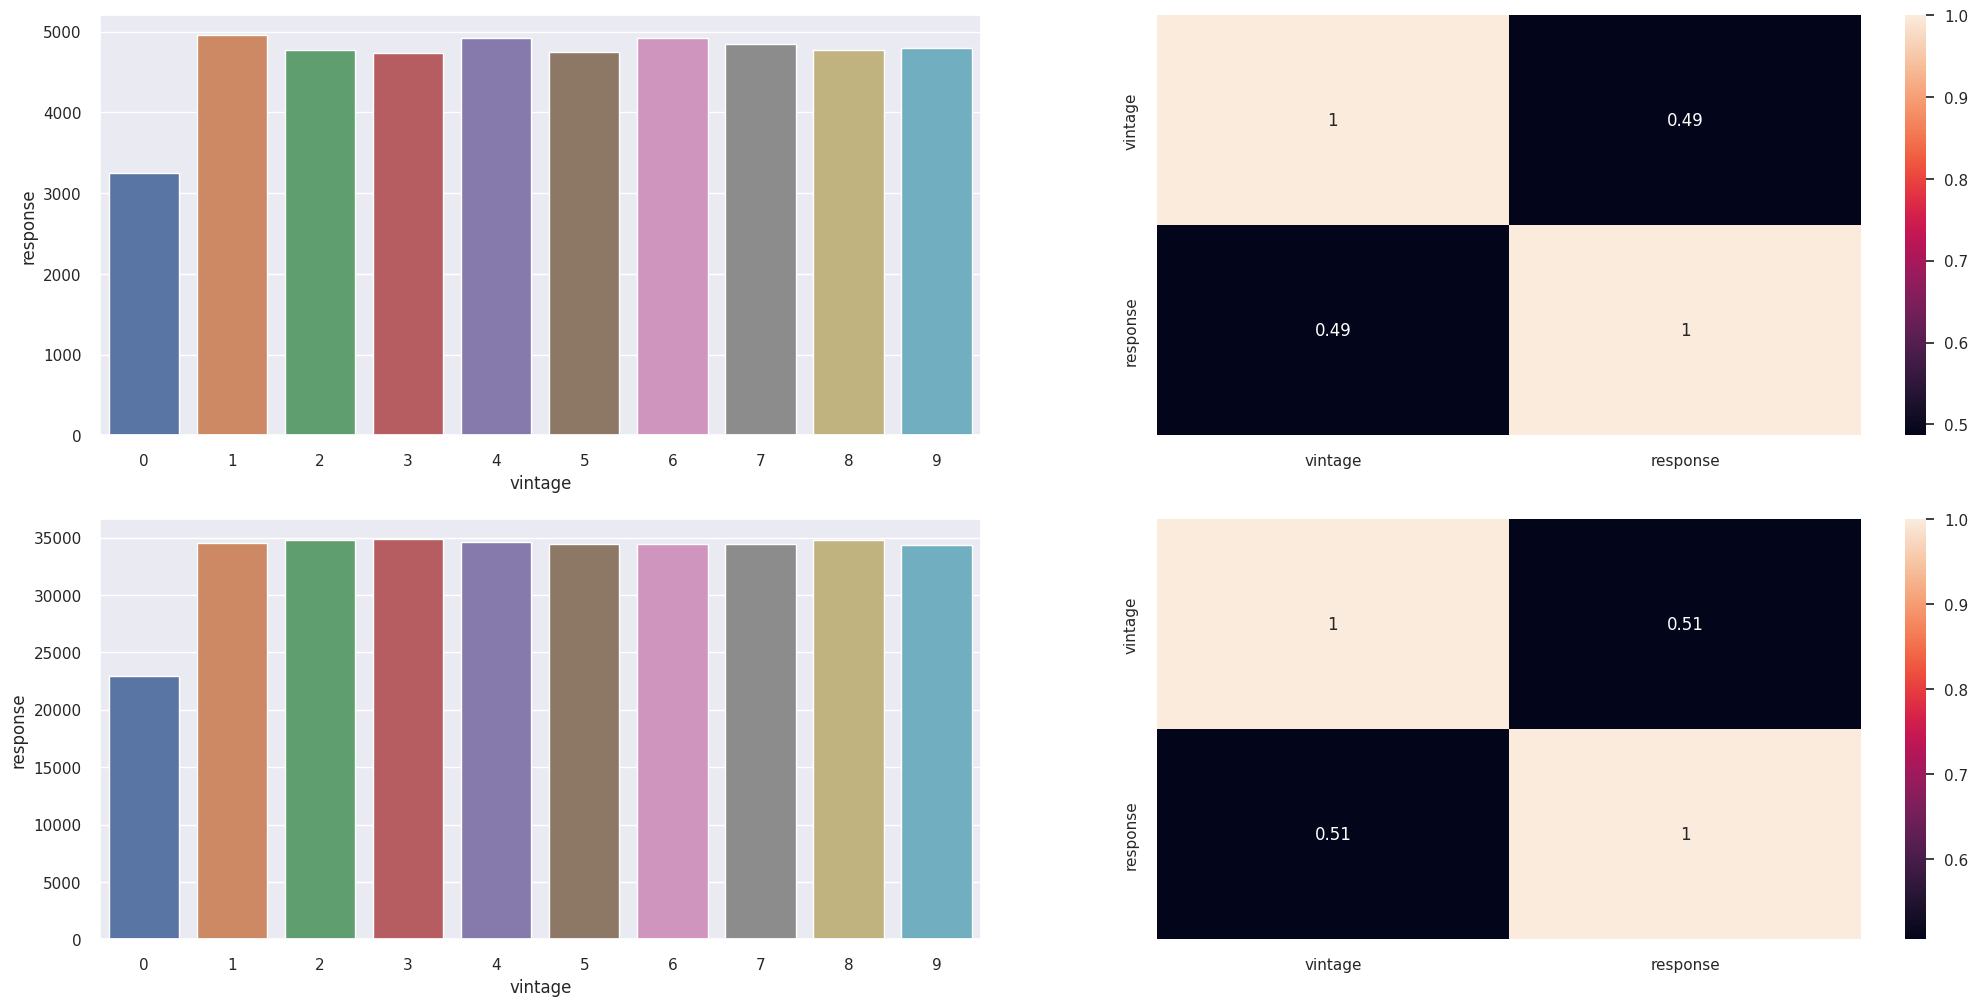

In [104]:
#filtering the people has interest
has_interest = df4.loc[df4['response'] == 1]

aux_1= has_interest[['vintage','response']].groupby('vintage').count().reset_index()

#plot the people has interest
plt.subplot(2,2,1)
sns.barplot(x= 'vintage', y = 'response', data= aux_1);

#plot the heatmap the people interest
plt.subplot(2,2,2)
sns.heatmap(aux_1.corr (method='pearson'), annot=True);

#people the people has not interest
has_not_interest = df4.loc[df4['response'] == 0]

aux_2 = has_not_interest[['vintage','response']].groupby('vintage').count().reset_index()

#plot the people not has interest
plt.subplot(2,2,3)
sns.barplot(x= 'vintage', y = 'response', data= aux_2);

#plot heatmap the people the has not interest
plt.subplot(2,2,4)
sns.heatmap(aux_2.corr (method='pearson'), annot=True);

### H8 - Carros mais antigos ocorrem mais danos.
**Falsa:** Carros mais antigos ocorrem menos danos

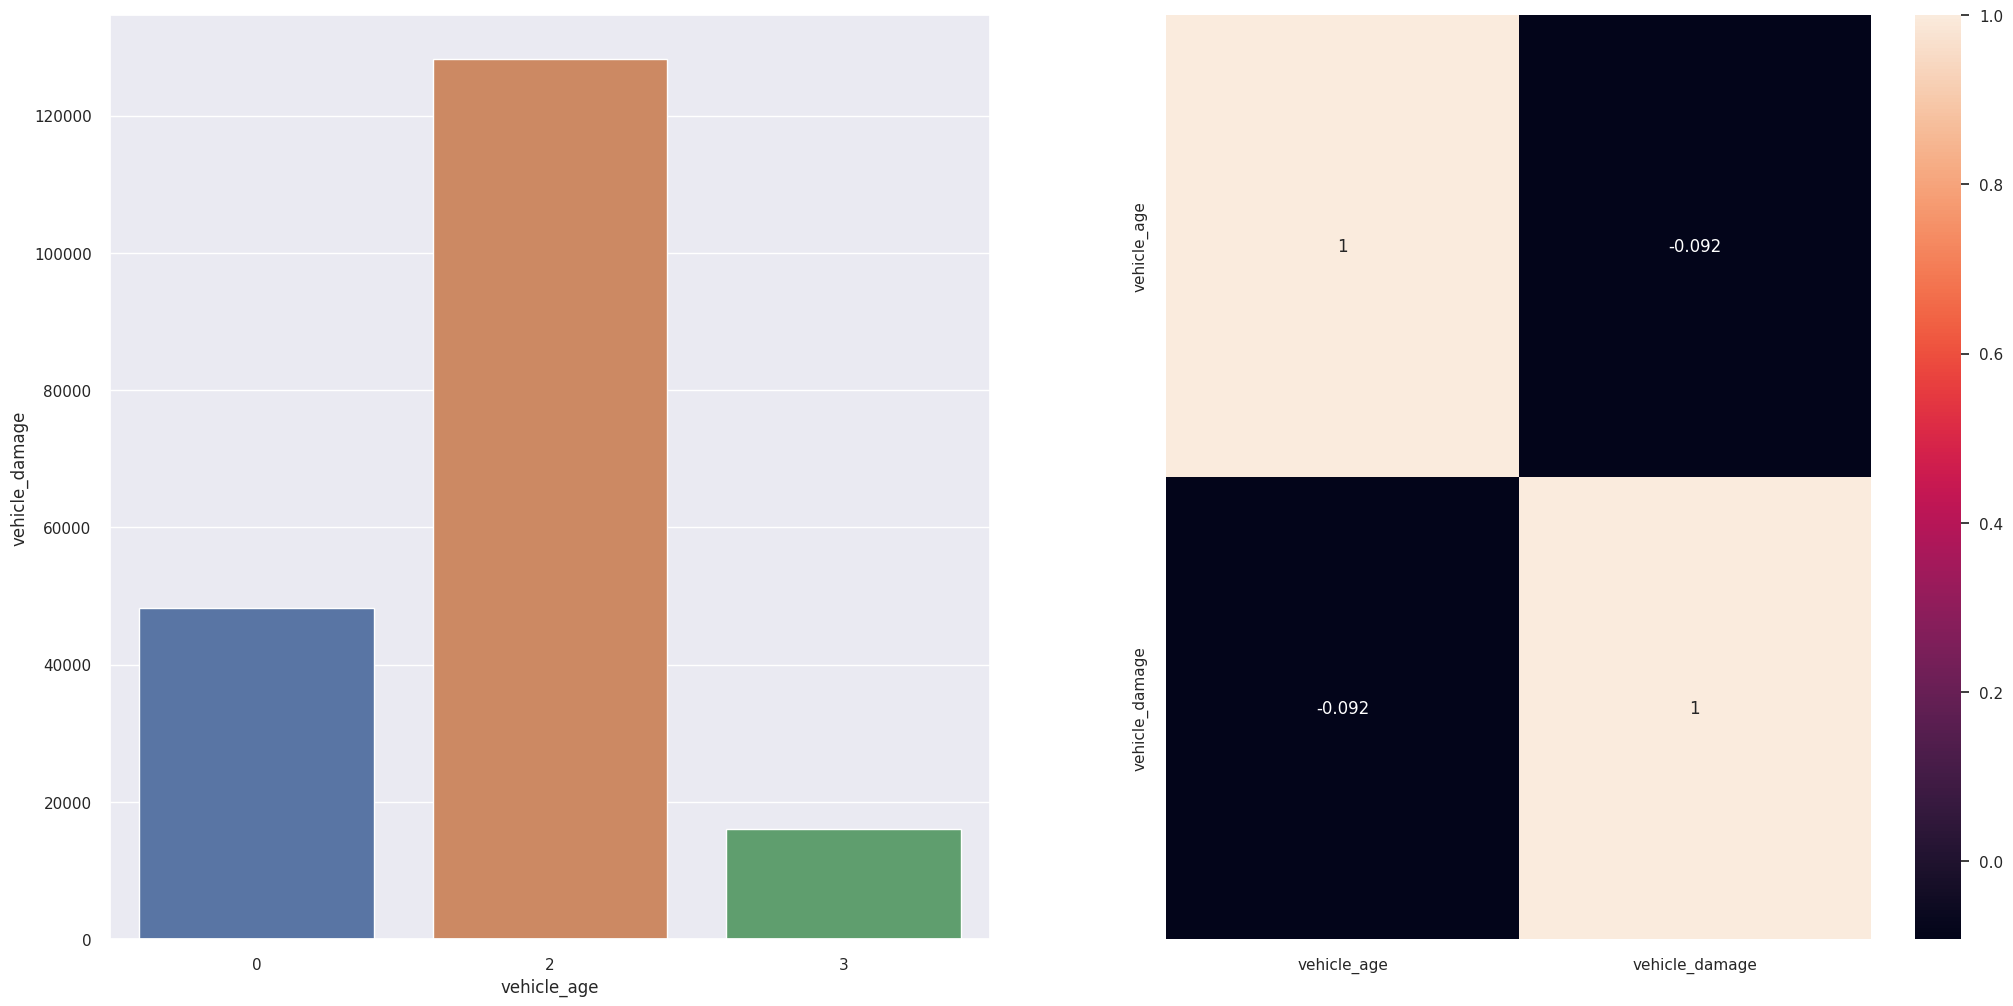

In [105]:
#filtering the data only with vehicle that past damage
aux_1 = df4.loc[df4['vehicle_damage']==1]

#grouping the dataset
aux_h9 = aux_1[['vehicle_damage','vehicle_age']].groupby('vehicle_age').count().reset_index()

#plot of bar
plt.subplot(1,2,1)
sns.barplot(x = 'vehicle_age',y= 'vehicle_damage', data = aux_h9);

#plot heatmap
plt.subplot(1,2,2)
sns.heatmap(aux_h9.corr (method='pearson'), annot=True);

### H9 - Pessoas que pagam mais pelo seguro de saúde tem menos interesse no seguro veícular.
**Falsa:** Pessoas que pagam mais pelo seguro de saúde tem mais interesse no seguro veícular do que as pessoas que pagam menos pelo seguro de saúde.

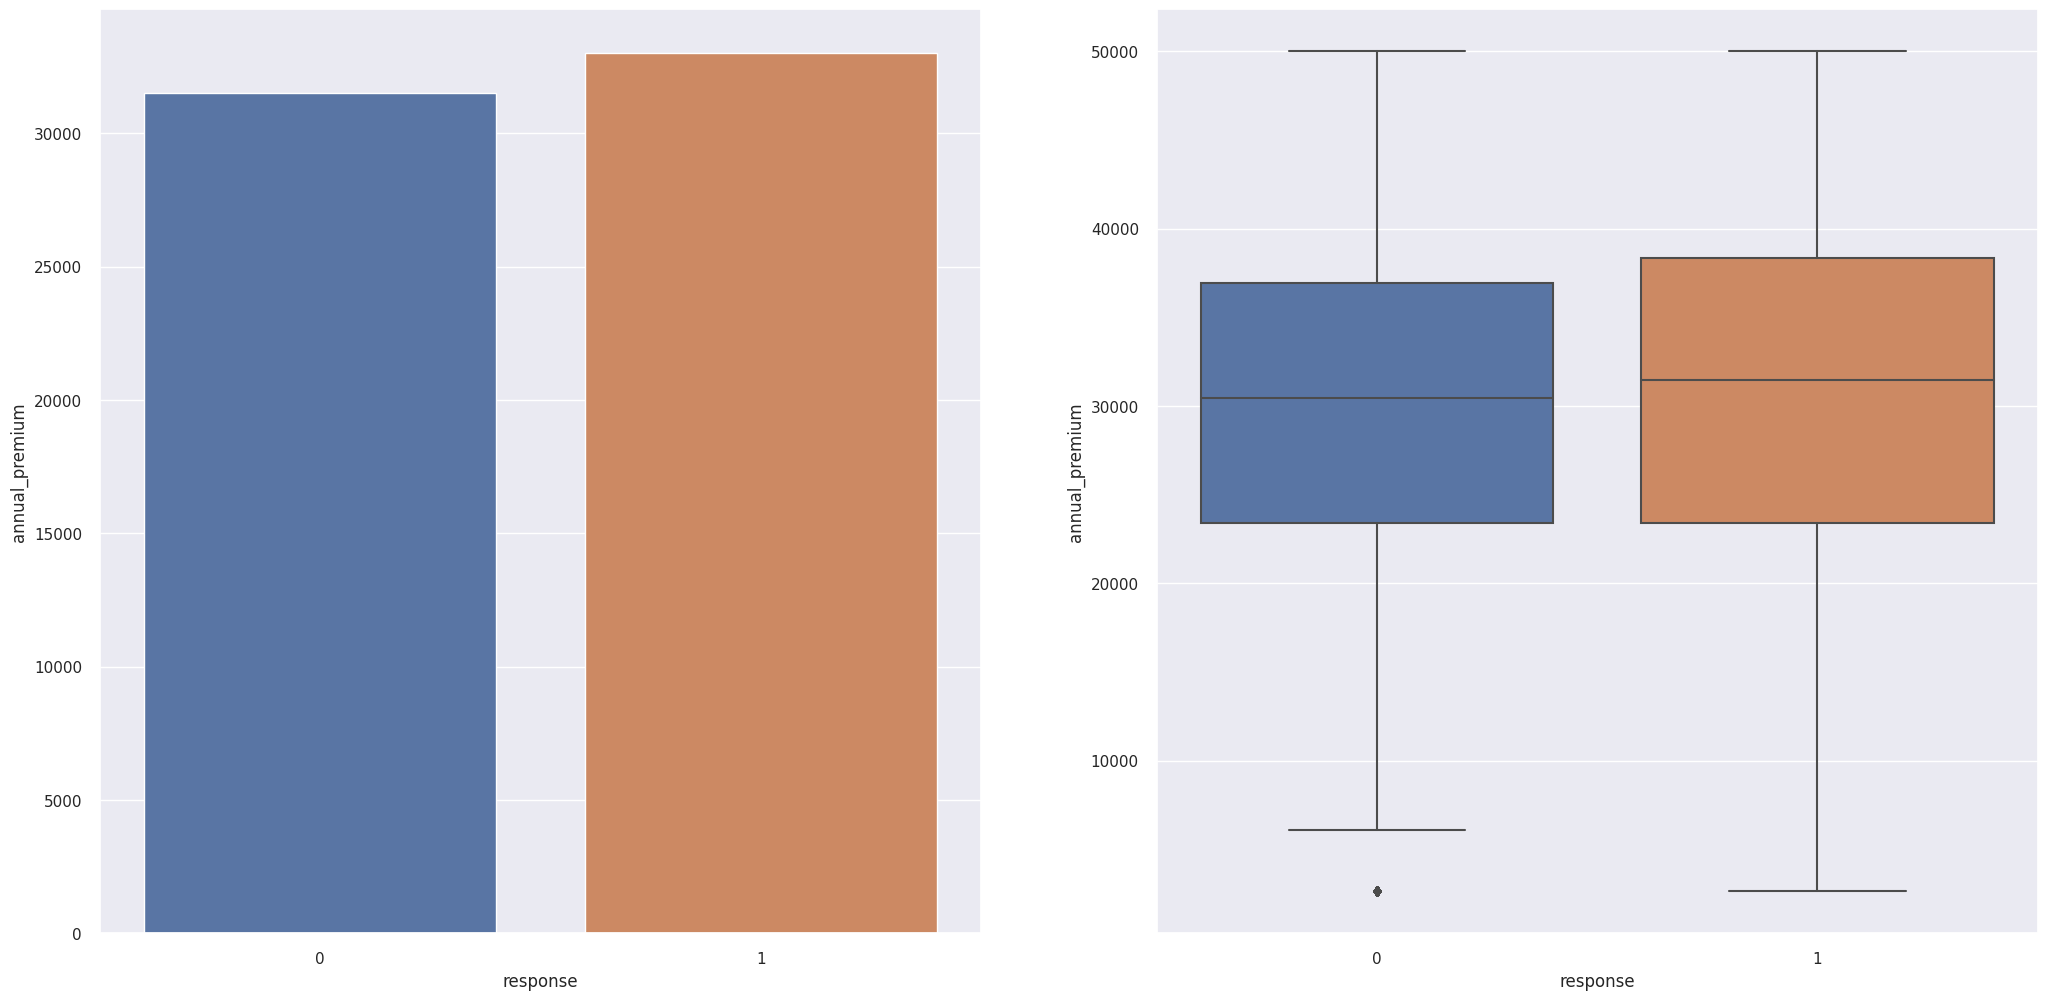

In [106]:
# created new variable
aux_h9 = df4[['annual_premium','response']].groupby('response').median().reset_index()

#plot comparative
plt.subplot(1,2,1)
sns.barplot(x = 'response', y = 'annual_premium', data= aux_h9);

#select the columns
aux_h9_boxplot = df4[['response','annual_premium']]

#filter the values annual premium
filter_boxplot = aux_h9_boxplot.loc[aux_h9_boxplot['annual_premium']<50000]

#plot boxplot
plt.subplot(1,2,2)
sns.boxplot(x='response', y='annual_premium', data= filter_boxplot);

### H10 - Pessoas que pagam menos pelo seguro de saúde tem mais registros de danos nos veículos.

**Falsa:** Pessoas que pagam menos pelo seguro de saúde tem menos registros de danos nos veículos.

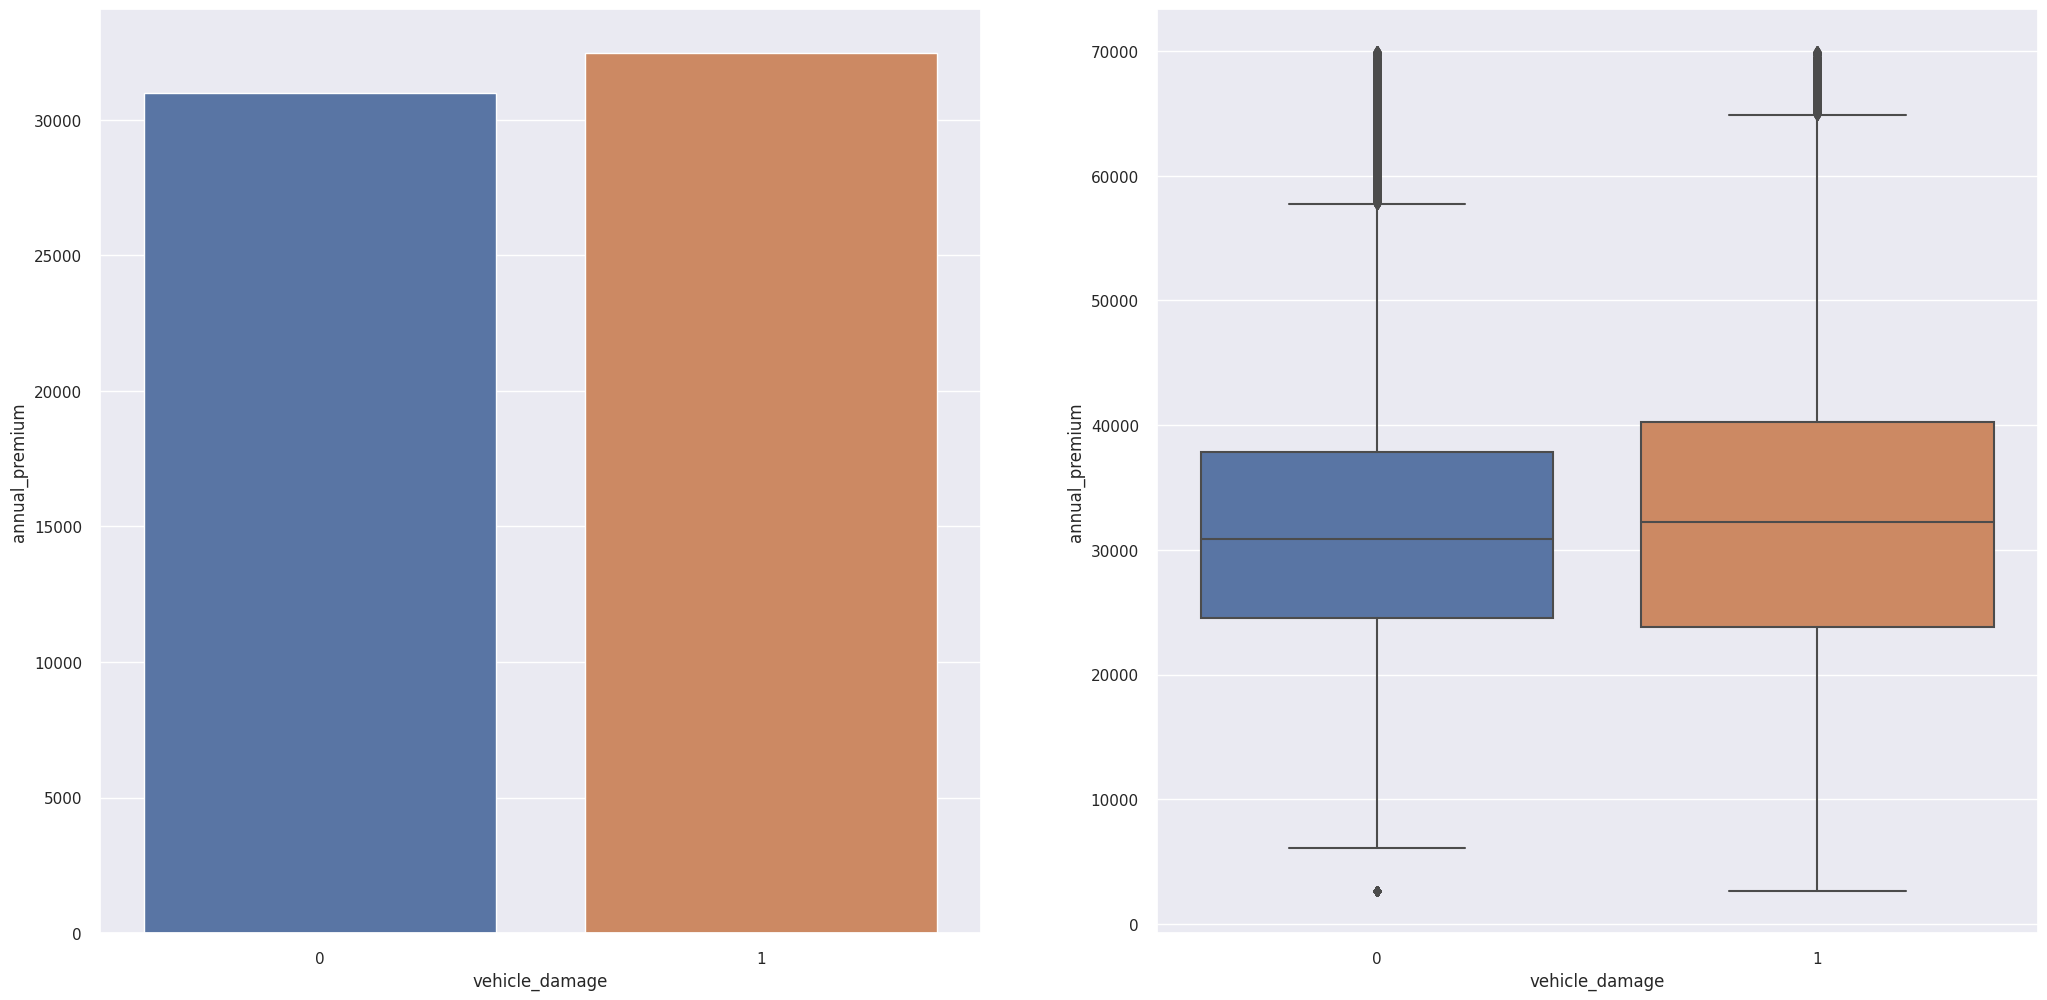

In [107]:
aux_h10 = df4[['annual_premium','vehicle_damage']].groupby('vehicle_damage').median().reset_index()

#plot of bar
plt.subplot(1,2,1)
sns.barplot(x = 'vehicle_damage', y = 'annual_premium', data= aux_h10);

auxh10 = df4[['vehicle_damage','annual_premium']]

filter_h10 = auxh10[auxh10['annual_premium']<70000]

plt.subplot(1,2,2)
sns.boxplot(x='vehicle_damage', y='annual_premium', data=filter_h10);

### H11 - Pessoas que pagam mais pelo seguro de saúde tem carros mais novos.
**Falsa:** Pessoas que pagam mais pelo seguro de saúde tem carros mais antigos.

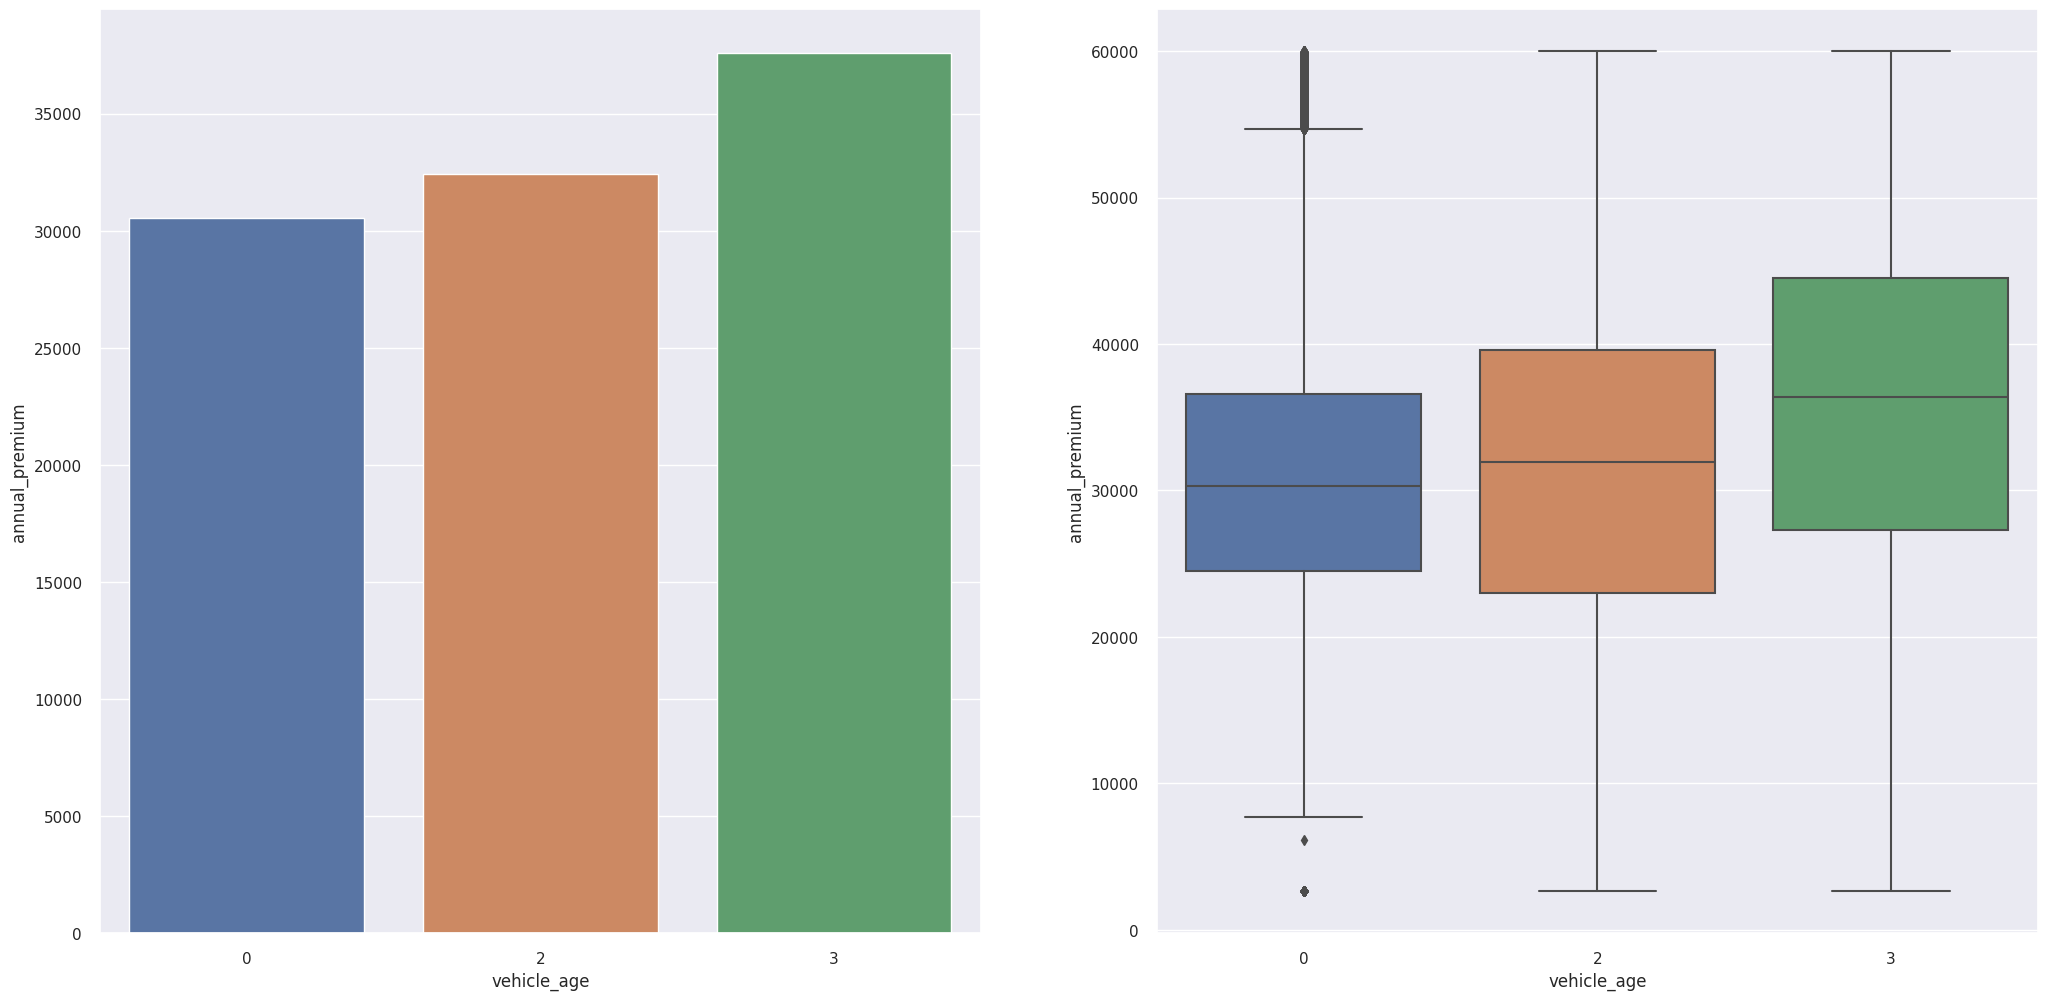

In [108]:
aux_h11 = df4[['annual_premium','vehicle_age']].groupby('vehicle_age').median().reset_index()

#plot the bar
plt.subplot(1,2,1)
sns.barplot(x = 'vehicle_age', y = 'annual_premium', data= aux_h11);

# =========================== boxplot ========================================== #

auxh11 = df4[['vehicle_age','annual_premium']]

#filter annual premium
filter_h11 = auxh11.loc[auxh11['annual_premium']<60000]

#plot boxplot
plt.subplot(1,2,2)
sns.boxplot(x='vehicle_age', y='annual_premium', data=filter_h11);


### 4.4.1 Sumary Hypothesis

In [109]:
tab = [ 
    ['Hypothesis','Conclusion','Relevance'],
    ['H1','True','Mean'],
    ['H2','True','Low' ],
    ['H3','True','High'],
    ['H4','True','High'],
    ['H5','True','High'],
    ['H6','True','Mean'],
    ['H7','False','High'],
    ['H8','False','High'],
    ['H9','False','High'],
    ['H10','False','High'],
    ['H11','False','High'] ]

print(tabulate(tab, headers= 'firstrow') )
      

Hypothesis    Conclusion    Relevance
------------  ------------  -----------
H1            True          Mean
H2            True          Low
H3            True          High
H4            True          High
H5            True          High
H6            True          Mean
H7            False         High
H8            False         High
H9            False         High
H10           False         High
H11           False         High


### 4.5 Analasy Mutivariable

### 4.5.1 Numerical Attributes

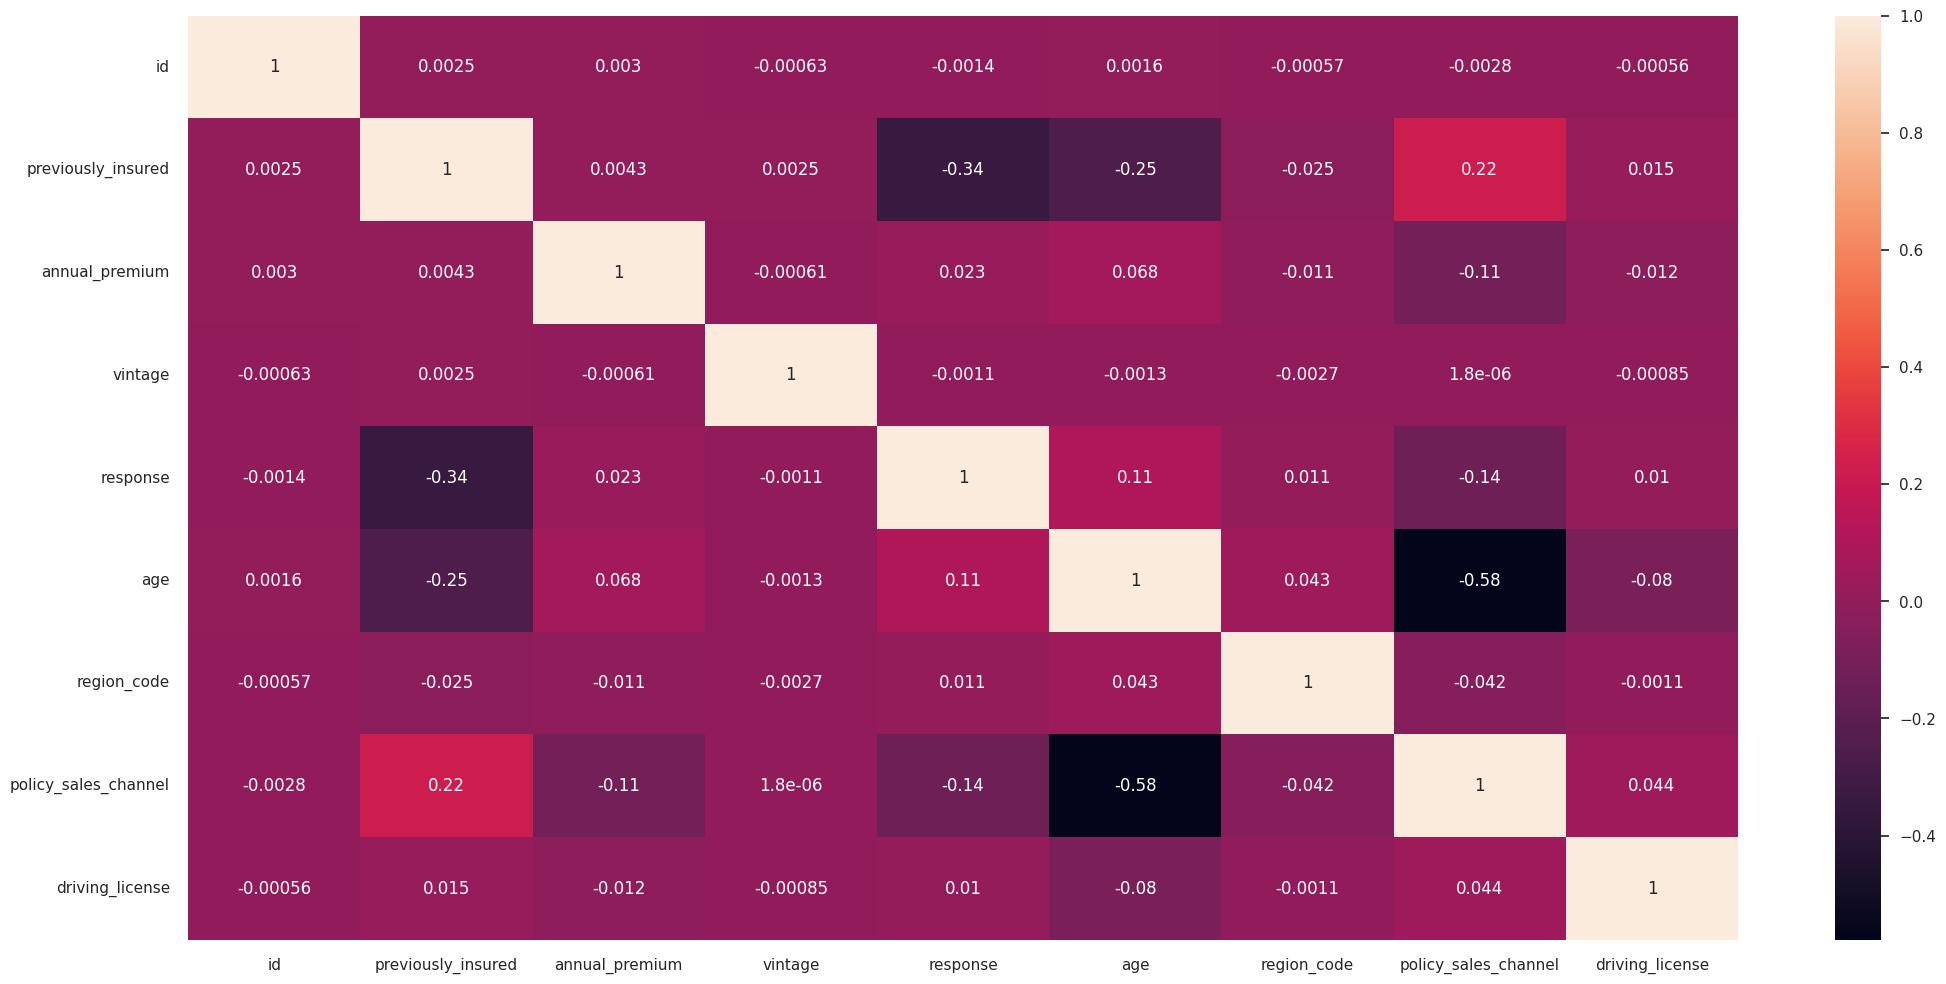

In [110]:
#plot heatmap of correlation numeric
sns.heatmap(num_attributes.corr(method='pearson'), annot= True );

# 5 - Data Preparation

In [111]:
df5 = df4.copy(deep=True)

## 5.1 - Split Data between train and test

In [112]:
# Data to model train 
X = df4.drop('response',axis=1)

# Data test of model
y = df4['response'].copy(deep=True)

# split the dataset between train and validation
x_train, x_validation, y_train, y_validation = ms.train_test_split( X, y, test_size =0.20)

#join the two dataset to model train
df5 = pd.concat( [x_train, y_train], axis=1 )

## 5.2 Standardizing the Data

In [113]:
#Normalizing the data
ss = StandardScaler()

df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)

## 5.2 Rescaling

In [114]:
# =================================== Target Enconding ===================================== #

#making the mean by region code in dataframe
target_enconding_region_code = df5.groupby('region_code')['response'].mean()

#add new scale in dataframe 
df5.loc[:, 'region_code'] = df5['region_code'].map(target_enconding_region_code)

# =============================== Frequency ===============================================#

#policy_sales_channel / frenquecy between dataset

#new variable with the frequency in dataset
fre_policy_sales_channel = df5.groupby('policy_sales_channel').size()/ len(df5)

# add in dataset the new rescaling
df5.loc[:,'policy_sales_channel'] = df5['policy_sales_channel'].map(fre_policy_sales_channel)

#====== vehicle_age =========

fre_vehicle_age = df5.groupby('vehicle_age').size()/ len(df5)

df5.loc[:,'vehicle_age'] = df5['vehicle_age'].map(fre_vehicle_age)

# ======================================== MinMax Scaler ================================================= #

#Pack to make rescaling

mmr = MinMaxScaler()

#
df5['vintage'] = mmr.fit_transform( df5[['vintage']].values )

df5['age'] = mmr.fit_transform( df5[['age']].values )

## 5.3 - Enconder

In [115]:
## ===================================== Target Enconder ======================================================= ##

target_gender = df5.groupby('gender')['response'].mean()

df5.loc[:,'gender'] = df5['gender'].map(target_gender)

In [116]:
df5.head()

,id,previously_insured,annual_premium,vintage,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,response
279794,330083,0,0.082353,0.222222,0.138374,0.000000,0.072344,0.056962,1,0.432708,1,0
184429,331095,1,-0.178047,0.333333,0.103630,0.738462,0.074009,0.209035,1,0.525303,0,0
64823,136778,1,0.400516,0.555556,0.103630,0.200000,0.073638,0.354243,1,0.432708,0,0
1567,12712,0,0.153255,0.111111,0.103630,0.353846,0.186590,0.001351,1,0.525303,1,0
327237,329137,0,1.211291,1.000000,0.138374,0.184615,0.186590,0.015684,1,0.525303,1,1


## 5.4 - Validation Preparation

In [117]:
x_validation['annual_premium'] = ss.fit_transform(x_validation[['annual_premium']].values )


# =================================== Target Enconding ===================================== #

#add new scale in dataframe 
x_validation.loc[:, 'region_code'] = x_validation['region_code'].map(target_enconding_region_code)

# =============================== Frequency ===============================================#

x_validation.loc[:,'policy_sales_channel'] = x_validation['policy_sales_channel'].map(fre_policy_sales_channel)

x_validation.loc[:,'vehicle_age'] = x_validation['vehicle_age'].map(fre_vehicle_age)

# ======================================== MinMax Scaler ================================================= #

x_validation['vintage'] = mmr.fit_transform( x_validation[['vintage']].values )

x_validation['age'] = mmr.fit_transform( x_validation[['age']].values )


x_validation.loc[:,'gender'] = x_validation['gender'].map(target_gender)

#remove all NaN
x_validation = x_validation.fillna(0)

# 6 - Feature Selection

In [118]:
df6 = df5.copy(deep=True)

### 6.1 - Split Dataframe Between and Test

In [119]:
#data preparation (exclude the feature response and the feature id)
x_train_n = df6.drop(['id','response'],axis=1)

#variable responde to train
y_train_n = y_train

### 6.2 - ExtraTreessClassifier as Feature Selection

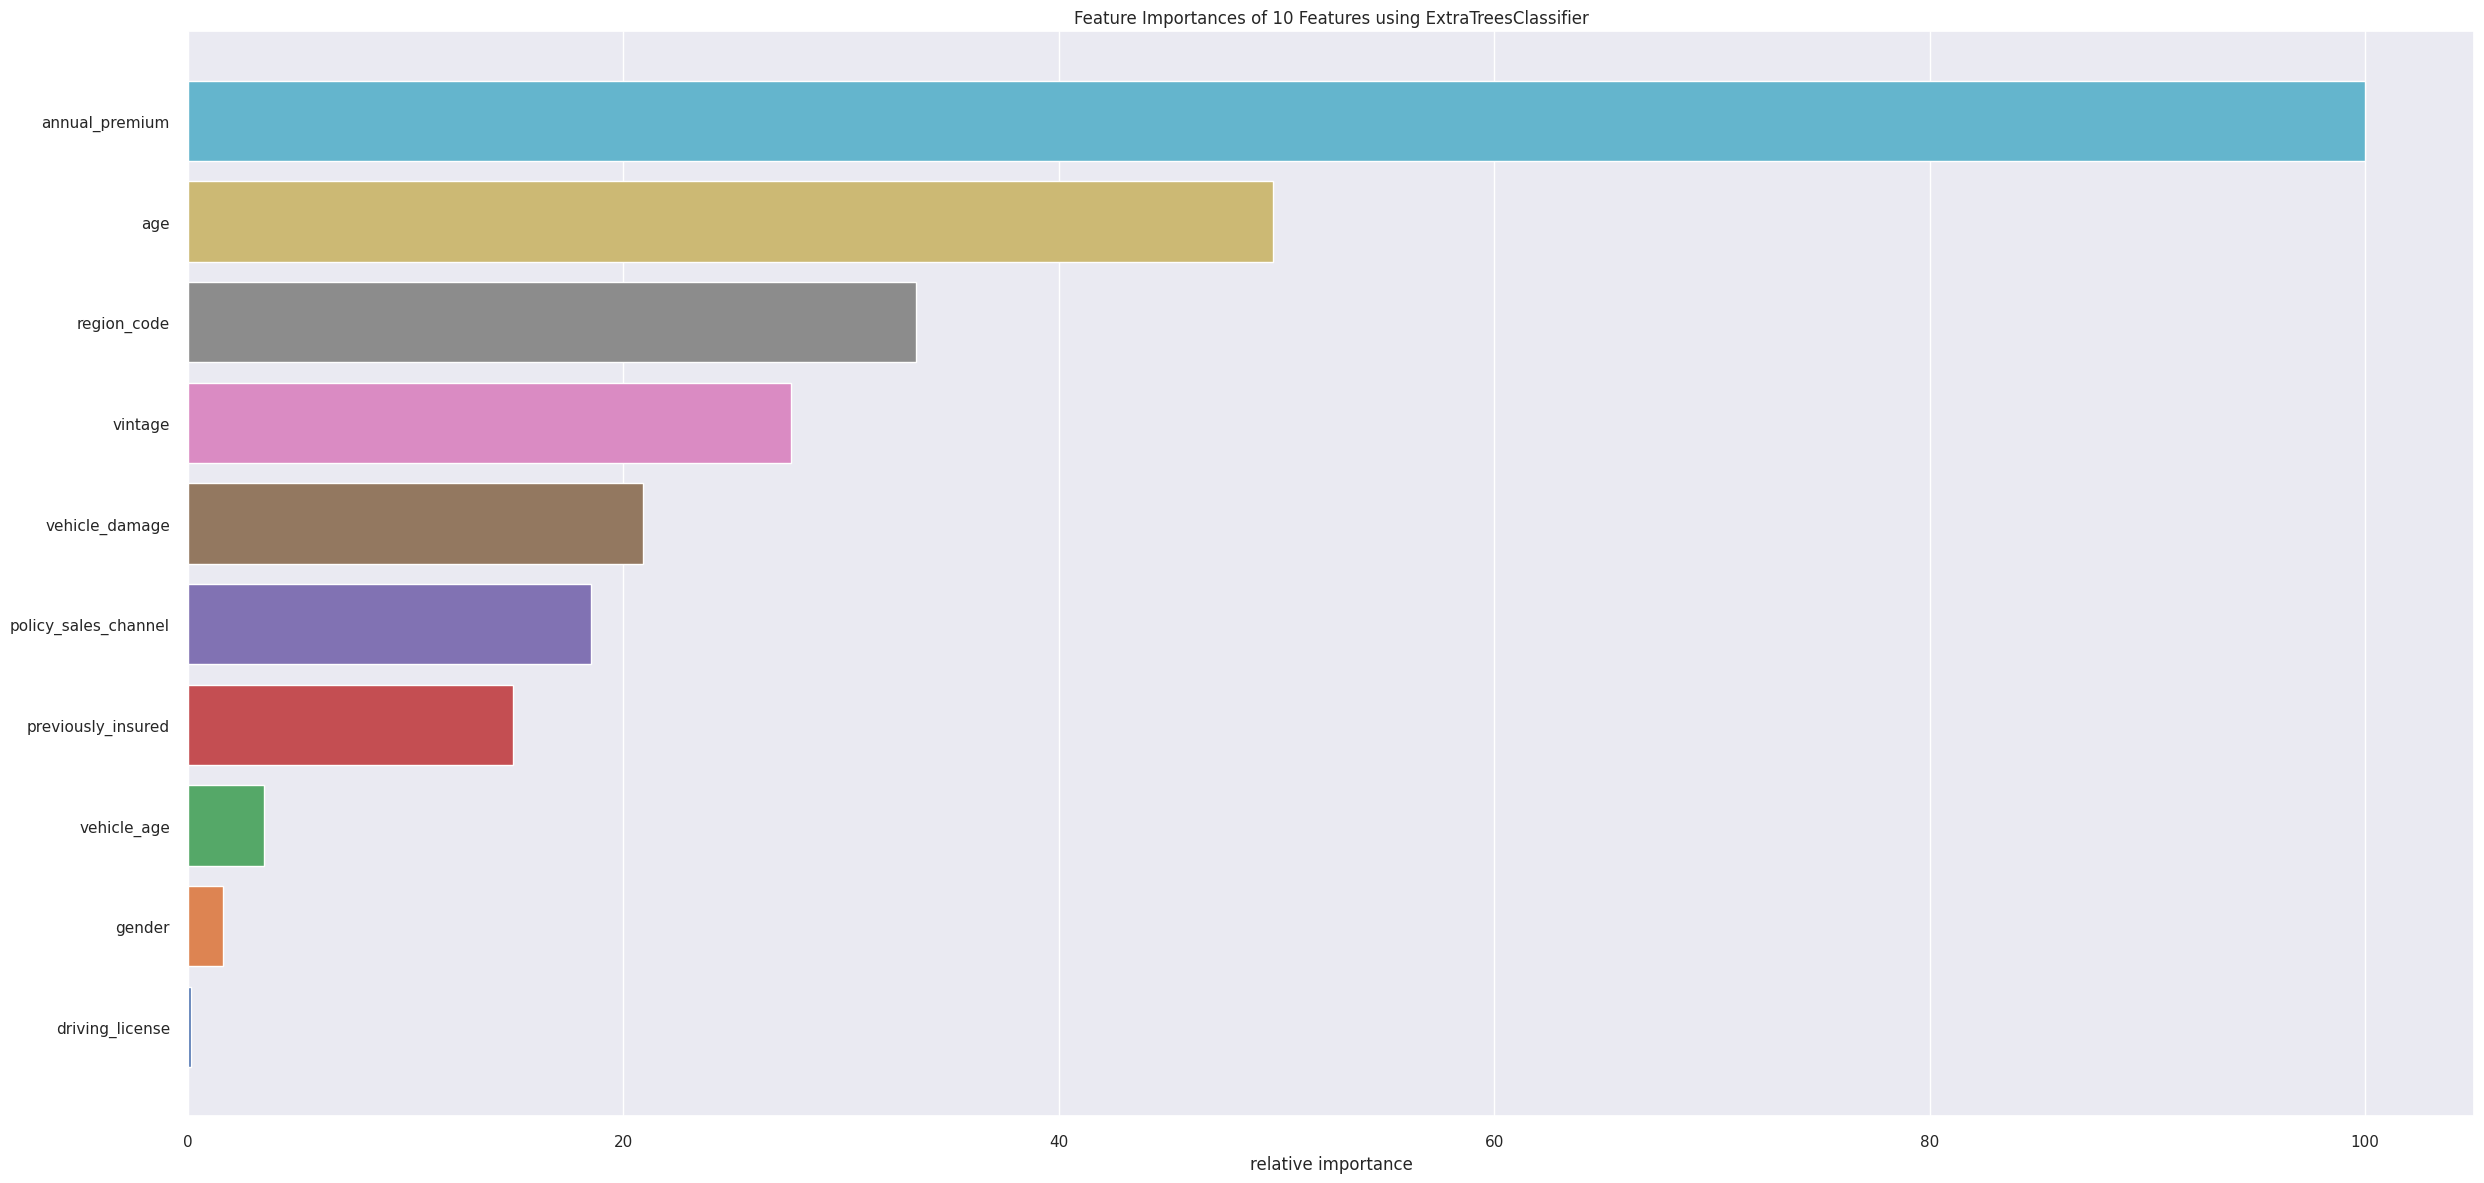

In [45]:
#definition of model to train
model = ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

#traning the model
viz = feature_importances(model, x_train_n, y_train_n)


## 6.3 - Mean the Features Importances

,1,2,3,4,5,6,7,8,9,10
feature,annual_premium,age,region_code,vintage,vehicle_damage,policy_sales_channel,previously_insured,vehicle_age,gender,driving_license
importance,0.369708,0.184183,0.123566,0.102307,0.077266,0.068456,0.055206,0.012826,0.005976,0.000506


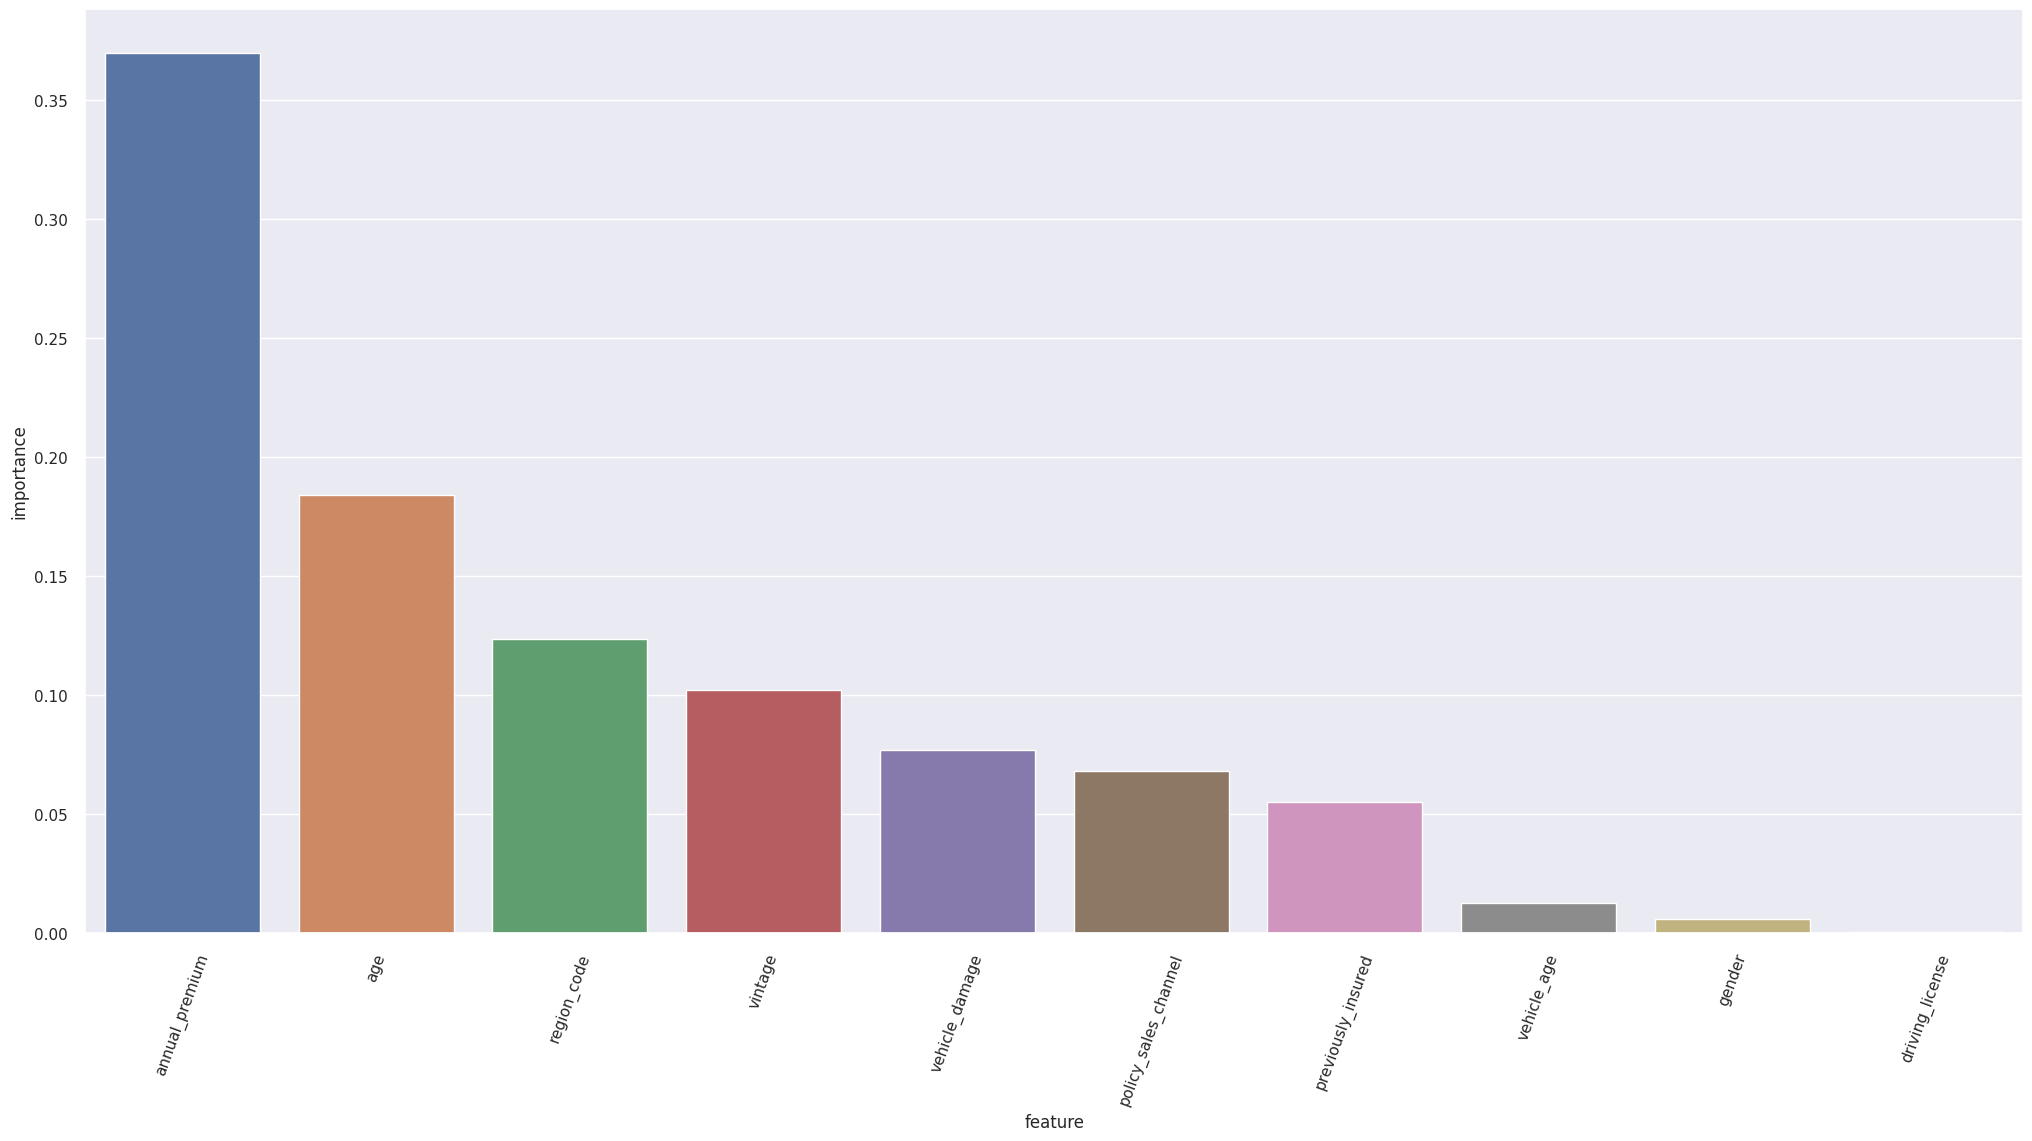

In [46]:
# ==================================== mean importances ================================= #

#variable of selection of model more importances
importances = model.feature_importances_

#empty dataframe to adict the ranking the features more importances
df_ranking = pd.DataFrame()

#making the columns of features importances
for i, j in zip(x_train_n, importances ):
    aux_ranking = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df_ranking = pd.concat([ df_ranking, aux_ranking ], axis=0 )


#list of importances orderned
df_list = df_ranking.sort_values('importance',ascending=False).T

#rename the index
df_list.columns = ['1','2','3','4','5','6','7','8','9','10']

#demostration dataframe of list
display(df_list)


#plot the mean features importances
sns.barplot(x='feature', y='importance', data= df_ranking.sort_values('importance', ascending=False ));
plt.xticks(rotation=70);

### 6.4 -Selection of Features Importances

In [120]:
# Features selected with more of 5 percent of importance
cols_selected = ['annual_premium',
                 'age',
                 'region_code'
                 ,'vintage',
                 'vehicle_damage',
                 'policy_sales_channel',
                 'previously_insured']


#
all_cols_selected = ['annual_premium',
                 'age',
                 'region_code'
                 ,'vintage',
                 'vehicle_damage',
                 'policy_sales_channel',
                 'previously_insured',
                 'íd',
                 'response' ]

# 7-  Machine Learning

In [121]:
df7 = df6.copy(deep=True)

In [122]:
#data train only with features seleceted by tree decision
x_train = df7[cols_selected]

# data of test only with features selected by tree decision
x_val = x_validation[cols_selected]

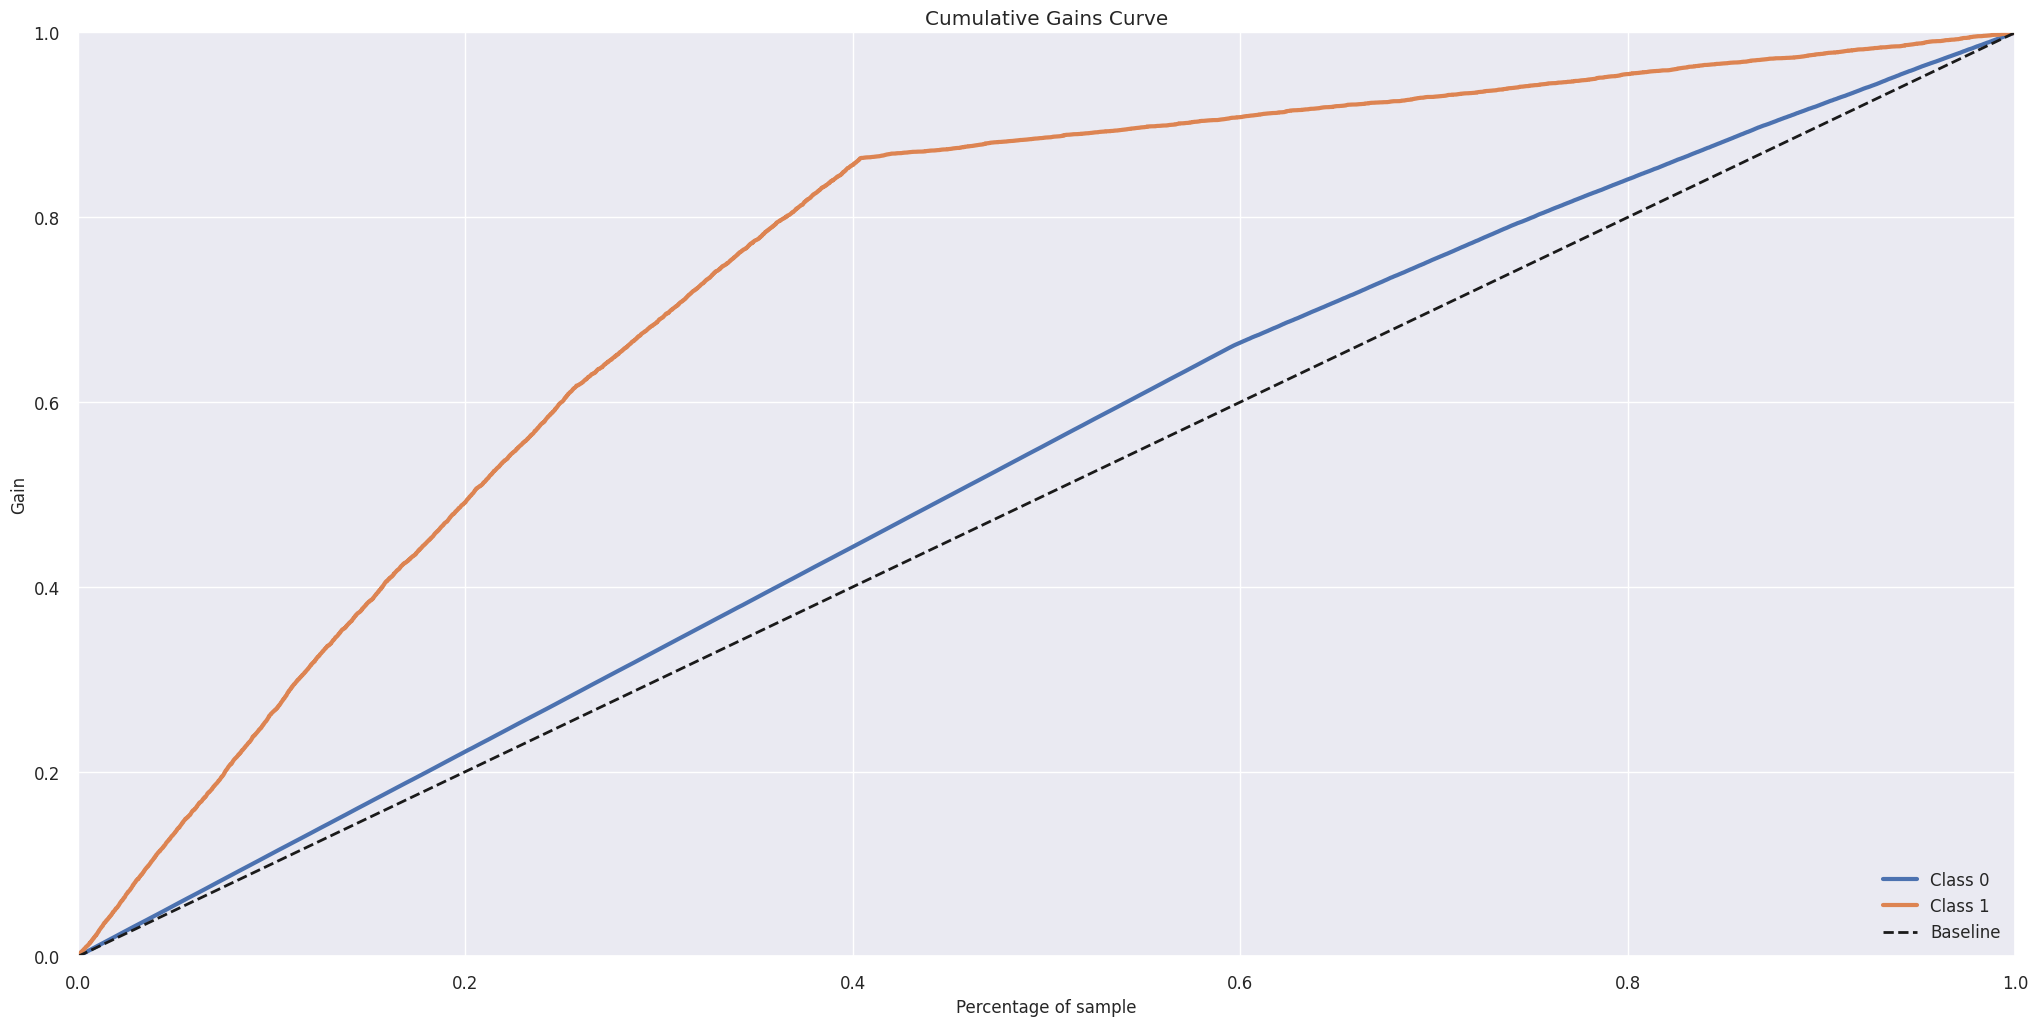

In [162]:
#knn model
knn_model = KNeighborsClassifier(n_neighbors=7).fit(x_train, y_train)

#prediction of probabilty 
knn_yhat = knn_model.predict_proba(x_val)

#Graph of cumulative gain
skplt.metrics.plot_cumulative_gain(y_validation, knn_yhat);

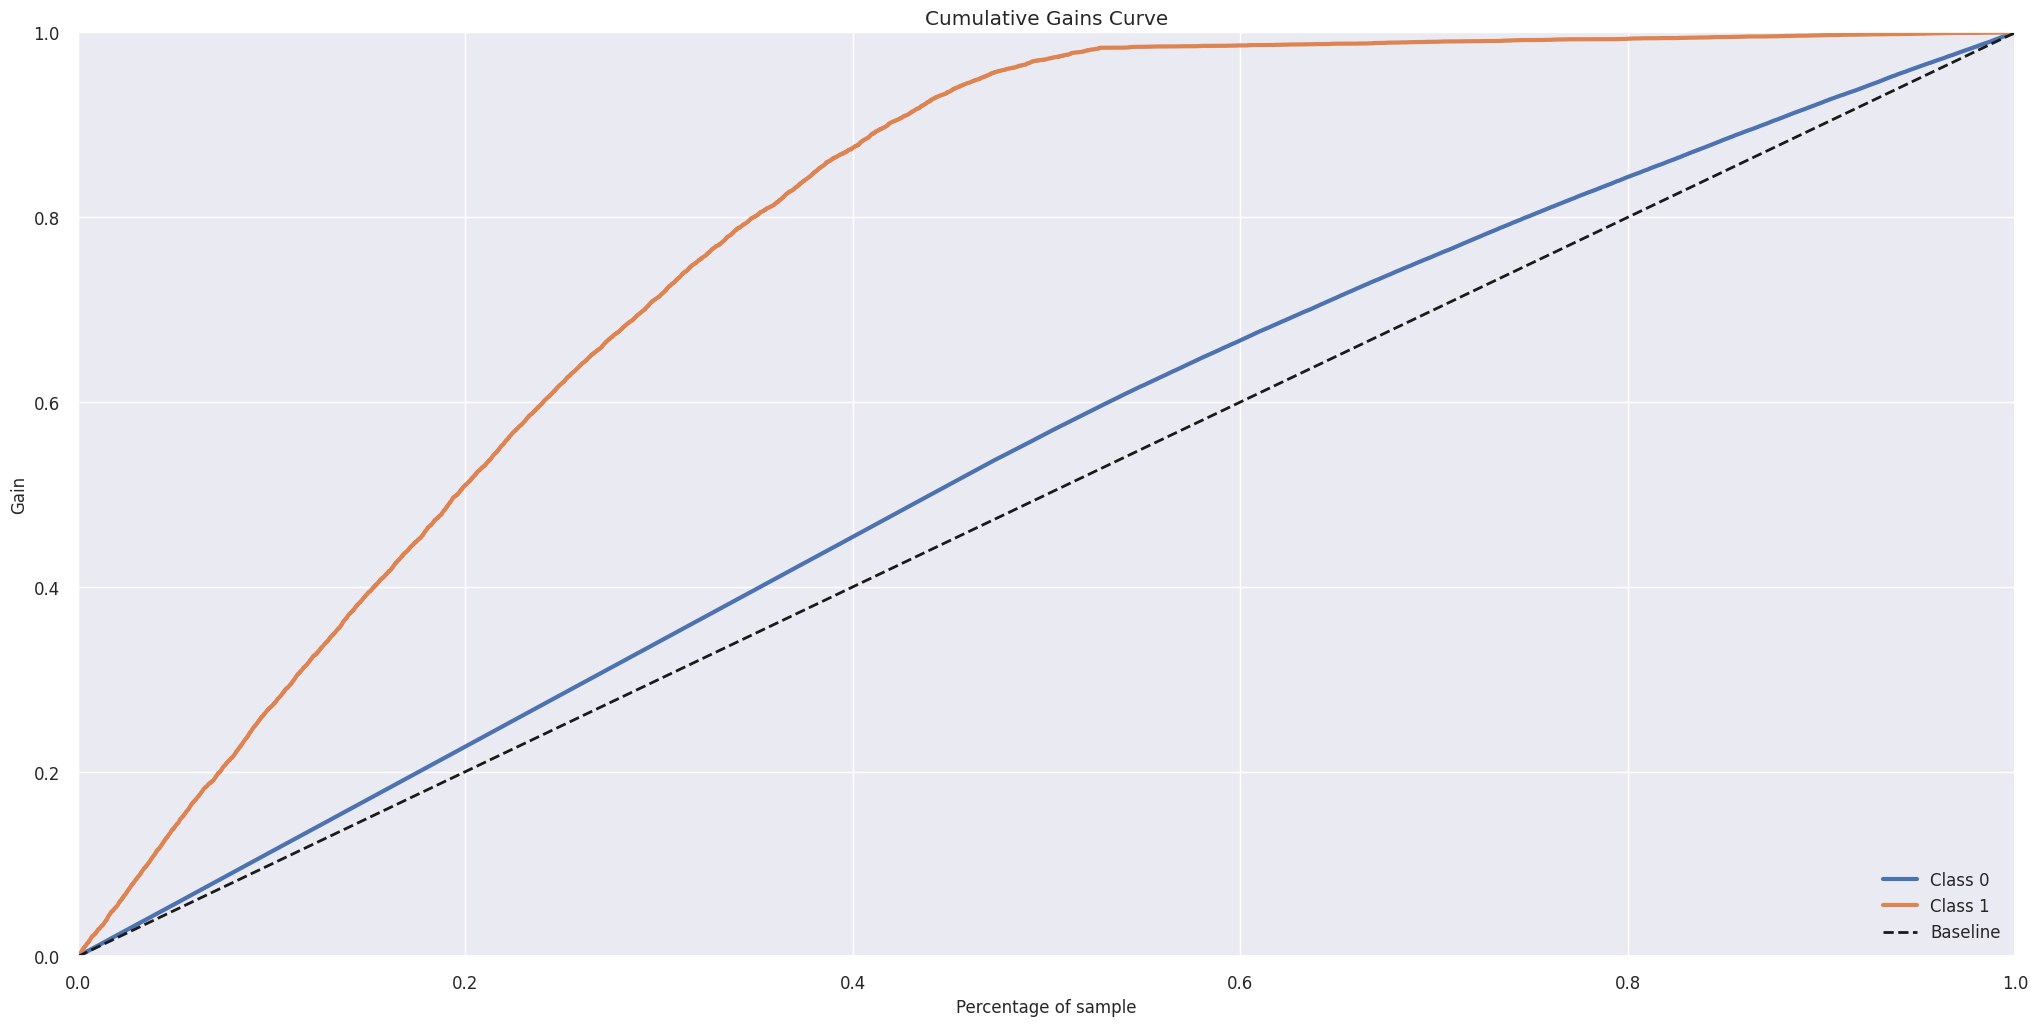

In [130]:
# Random Forest model
rf = RandomForestClassifier().fit(x_train, y_train)

#prediction of probabilty
rf_yhat = rf.predict_proba(x_val)

#Graph cumulative gain 
skplt.metrics.plot_cumulative_gain(y_validation, rf_yhat);

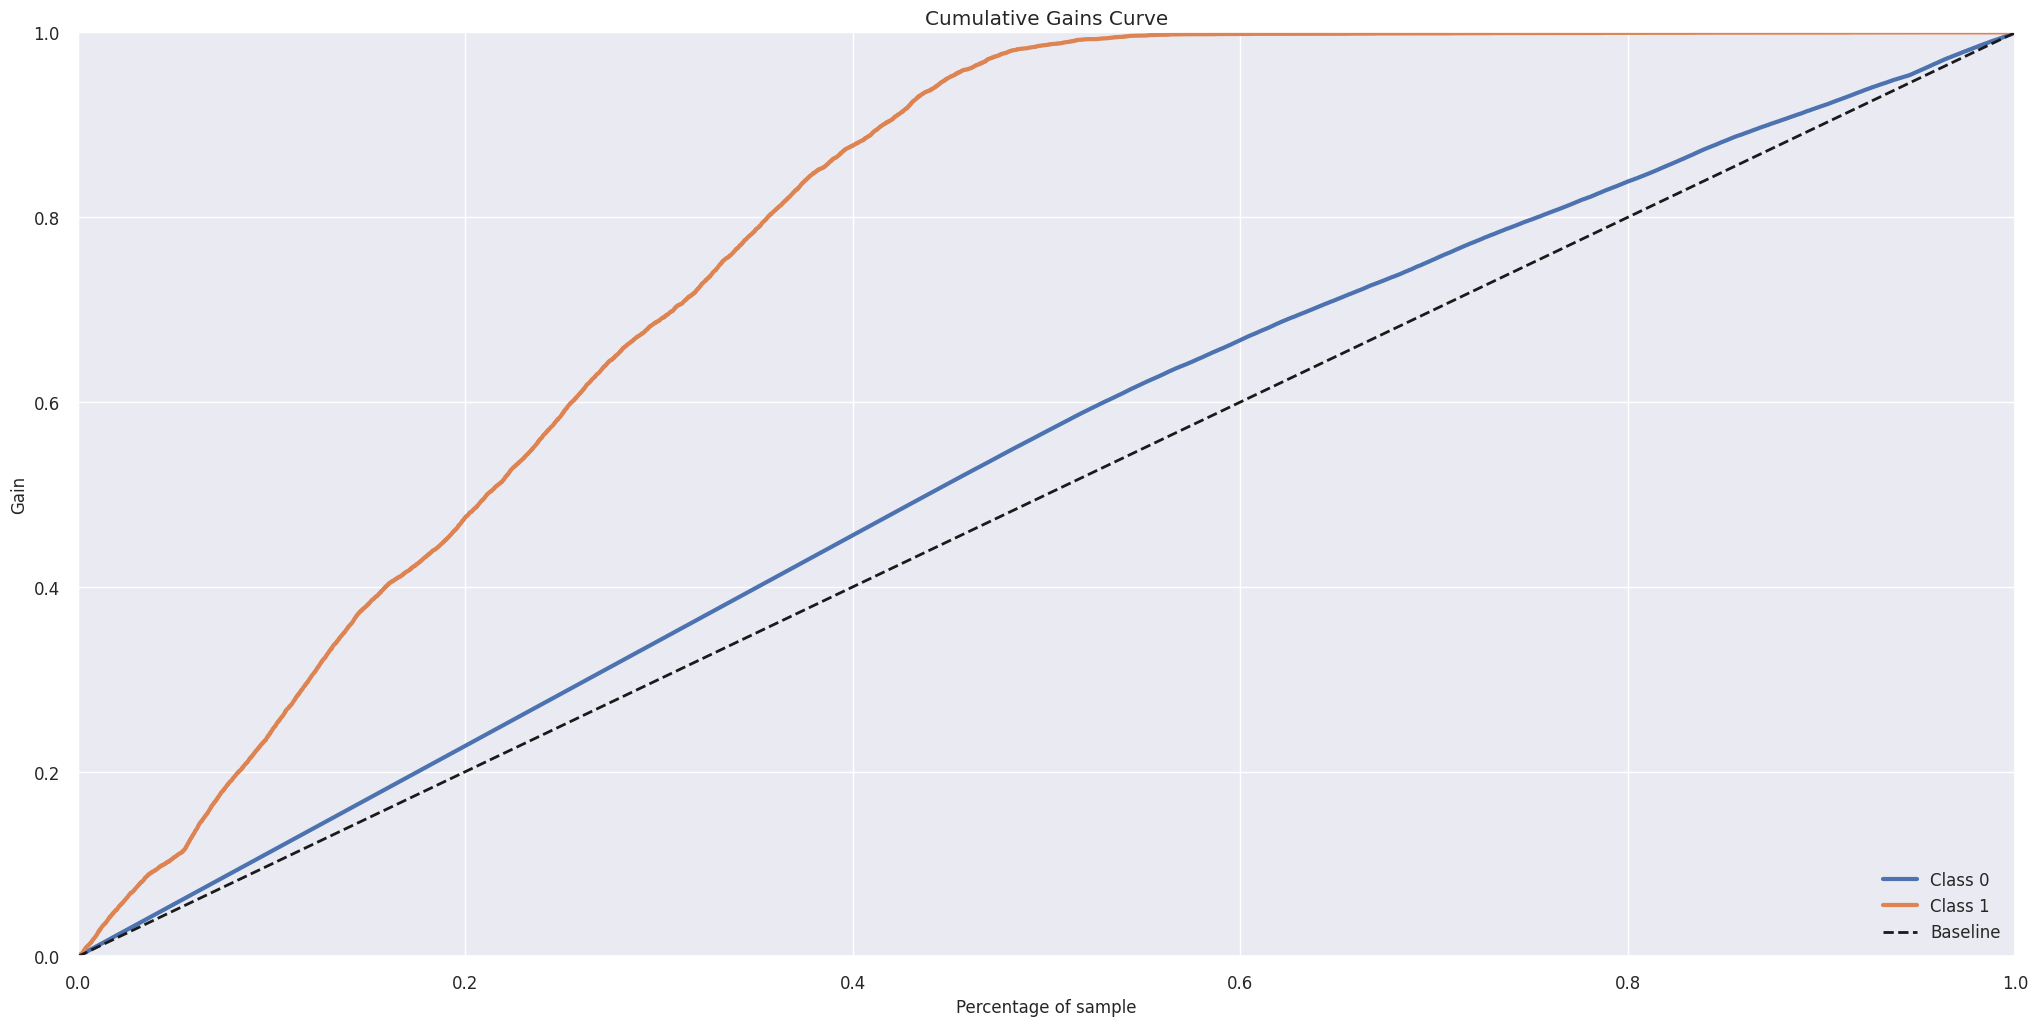

In [131]:
# Logist Regression Model
lr = LogisticRegression().fit(x_train, y_train)

# prediction of probabilty
yhat_lr = lr.predict_proba(x_val)

#Graph of cumulative gain 
skplt.metrics.plot_cumulative_gain(y_validation, yhat_lr);

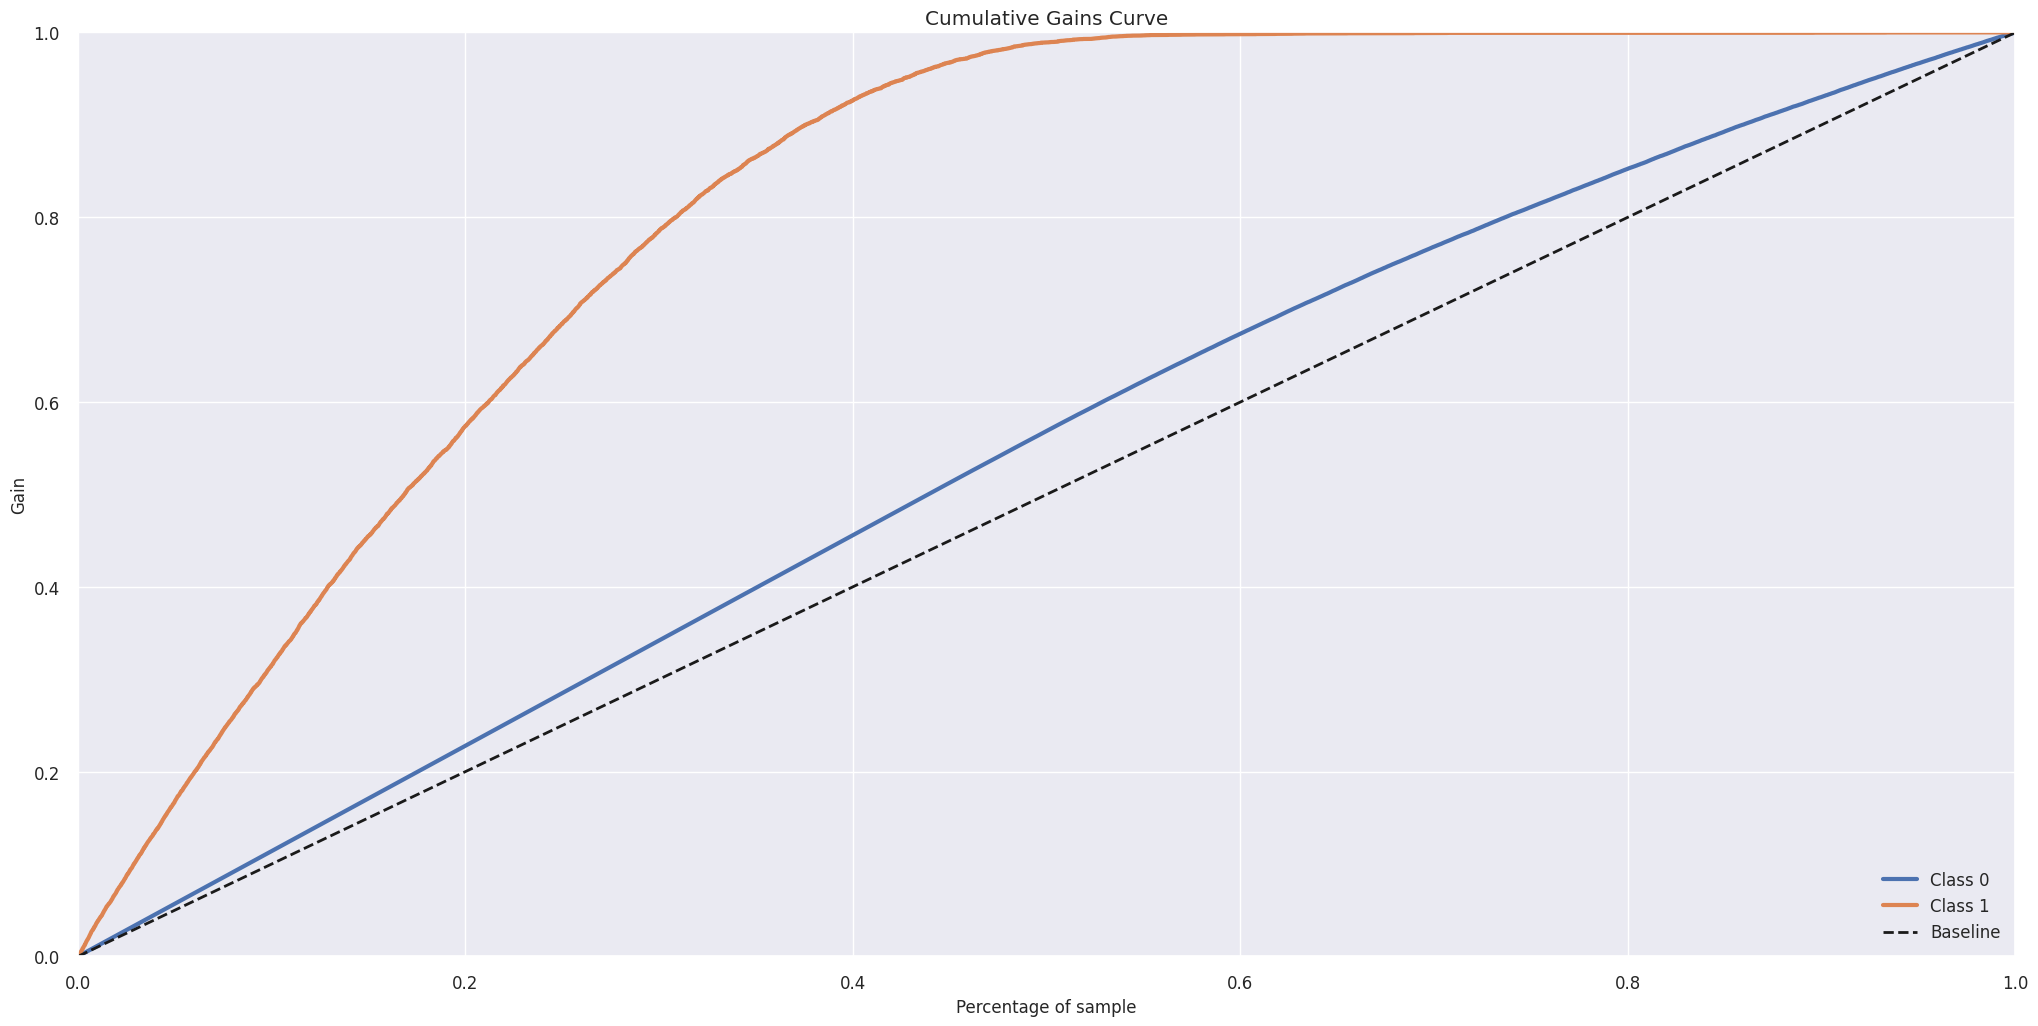

In [132]:
# Xboost Classifier Model 
xgb_cl = xgb.XGBClassifier().fit(x_train, y_train)

# Prediction of probabilty
xgb_yhat = xgb_cl.predict_proba(x_val)

# Grapg of Cumulative Gain 
skplt.metrics.plot_cumulative_gain(y_validation, xgb_yhat);

In [164]:
df8 = x_validation.copy(deep=True)

In [165]:
df8.head()

,id,previously_insured,annual_premium,vintage,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage
161674,147992,0,0.060677,0.000000,0.138374,0.569231,0.186590,0.209035,1,0.525303,1
69765,176052,0,0.329698,0.777778,0.138374,0.369231,0.186590,0.017646,1,0.525303,1
151429,67162,0,3.062730,0.666667,0.103630,0.538462,0.186590,0.209035,1,0.041989,1
338796,41805,0,0.813594,1.000000,0.103630,0.323077,0.122322,0.194170,1,0.525303,1
58554,86631,1,0.286286,1.000000,0.138374,0.076923,0.121420,0.354243,1,0.432708,0


In [166]:
df8['response'] = y_validation.copy(deep=True)

df8['response'].head(3)

161674    0
69765     0
151429    1
Name: response, dtype: int64

In [167]:
#df8['score'] = xgb_yhat[:,1].tolist()
df8['score'] = knn_yhat[:,1].tolist()


df8['score'] = df8.score.sort_values(ascending=False)

df8['score'].head(3)

161674    0.285714
69765     0.571429
151429    0.285714
Name: score, dtype: float64

In [168]:
#reset index of all dataset
df8 = df8.reset_index(drop=True)

df8.head()

,id,previously_insured,annual_premium,vintage,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,response,score
0,147992,0,0.060677,0.000000,0.138374,0.569231,0.186590,0.209035,1,0.525303,1,0,0.285714
1,176052,0,0.329698,0.777778,0.138374,0.369231,0.186590,0.017646,1,0.525303,1,0,0.571429
2,67162,0,3.062730,0.666667,0.103630,0.538462,0.186590,0.209035,1,0.041989,1,1,0.285714
3,41805,0,0.813594,1.000000,0.103630,0.323077,0.122322,0.194170,1,0.525303,1,0,0.285714
4,86631,1,0.286286,1.000000,0.138374,0.076923,0.121420,0.354243,1,0.432708,0,0,0.000000


In [169]:
#created feature of ranking
df8['ranking'] = df8.index + 1

df8.head(3)

,id,previously_insured,annual_premium,vintage,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,response,score,ranking
0,147992,0,0.060677,0.000000,0.138374,0.569231,0.18659,0.209035,1,0.525303,1,0,0.285714,1
1,176052,0,0.329698,0.777778,0.138374,0.369231,0.18659,0.017646,1,0.525303,1,0,0.571429,2
2,67162,0,3.062730,0.666667,0.103630,0.538462,0.18659,0.209035,1,0.041989,1,1,0.285714,3


In [170]:
#select the feature more importance

df8 = df8[['id','response','score','ranking']].copy(deep=True)

In [171]:
df8['precision_at_k'] = df8['response'].cumsum() / df8['ranking']


In [172]:
df8.head()

,id,response,score,ranking,precision_at_k
0,147992,0,0.285714,1,0.000000
1,176052,0,0.571429,2,0.000000
2,67162,1,0.285714,3,0.333333
3,41805,0,0.285714,4,0.250000
4,86631,0,0.000000,5,0.200000


In [173]:
def precision_at_k(data,target_col, k=20000):
    
    data = data.reset_index(drop=True)
    data['ranking'] = data.index + 1
    data['precision_at_k'] = target_col.cumsum() / data['ranking']
    
    return data.loc[k,'precision_at_k']

In [174]:
def precision_at_k_2(data, k=20000):
    
    data = data.reset_index(drop=True)
    data['ranking'] = data.index + 1
    data['precision_at_k'] = df8['response'].cumsum() / data['ranking']
    
    return data.loc[k,'precision_at_k']

In [175]:
precision_test = precision_at_k_2(df8,k=50)


precision_test *100

7.8431372549019605

In [111]:
from sklearn.metrics import top_k_accuracy_score

top_k_accuracy_score(df8['response'],df8['precision_at_k'], k=50)

#top_k_accuracy_score(y_val, xgb_yhat, k=2)

/home/guilherme/Documentos/repos/pa_health_cross_sell/healthcrosssell/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1777: UndefinedMetricWarning: 'k' (50) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(


1.0